# Project Description
There have been no major deviations from the initial timeline.The project schedule remains the same as the initial plan, with data acquisition, cleaning, and exploratory analysis already completed. The remaining tasks will focus on hypothesis testing, final analysis, and report preparation.

The project will conclude with the final analysis and interpretation of results by April 15, 2025.

In the final analysis, we will have

**Descriptive Statistics**, which answer how the Number of Aircraft Incidents varying by Year and month, how frequently the most common cause of incidents occur, the most common Phase of flight during the incident, the common geographic location of the incident, and what percent of injuries are fatal.

**Correlation Analysis** using ANOVA to explain the correlation between weather conditions and aircraft age to incident occurrence, another ANOVA to determine if the number of incidents is statistically different during different lighting conditions, and Moran's I to determine any correlation between geographic location and if an incident happened. If we decide that assumptions are not accurate we will use other methods like chi-squared tests that can handle different assumptions.

**Regression Models** to predict incident occurrence using weather conditions, altitude, and age of aircraft; to predict severity of aircraft damage and injuries using age of the aircraft and fuel on board, and to understand the findings using natural language processing.

# Data Description
**Data Acquisition**: We gathered data from three datasets from "National Transportation Safety Board" which are "avall.mdb" and "Pre2008.mdb," which has data post-1982, and another dataset is "Pre1982.mdb" which has data before 1982. Extracted all the necessary variables for analysis and hypothesis testing and made into .csv files.

**Data Cleaning**: After extracting the required variables from data files, we handled issues such as missing values using methods like .isnull() and .isna(). We have dealt with the missing values by dropping rows, depending on the proportion of missingness. Checked for and removed duplicate rows in the dataset to ensure no redundancy in the data, which might skew the results if not done. Examined the data to differentiate between Numeric and Categorical variables to ensure correct data types are used for analysis, which is crucial for statistical analysis and machine learning models.
All the Outliers are removed to ensure the statistical values are not affected.

**Exploratory Analysis**: All the necessary Exploratory Analyses are conducted to understand the data correctly. 
A dataset before 1982 has 87,039 entries and 20 columns in total. And the one after 1982 has 91,517 entries and 22 columns.

Both datasets have considerable missing values in key attributes, which might impact the statistical analysis. In the Post 1982 dataset, missing values are significant in Latitude, Fuel_on_board, wx_int_precip, and wind_vel_kts. Likewise, Pre-1982 shows missing values in Altitude of occurrence and Cause, limiting the statistical insights.

An analysis of the Number of Incidents per year shows a notable change in the Number of incidents from years before 1982 and after 1982, showing a significant decrease in incidents year by year.

The top 10 incident causes were plotted, with Personal-issue_Task-performance being the most common cause. The top 10 models of aircraft involved in most incidents were also plotted; it shows that the model PA-28 was the most commonly involved in the incidents before 1982, and the 152 model aircraft was the most frequently engaged after 1982.
Most Incidents occurred during the DayLight conditions both before 1982 and after 1982. 

Next Statistical Analysis and Hypothesis testing will be done, and the results will be presented in the coming weeeks.


# Ethical Data Concerns
No reasonable cause for discouraging viewers to fly has been discovered. Reported causes have been counted, but full pictures of the incidents have not been captured. To more fully describe the incidents and explain level of safety, percent chance of experiencing an incident on any given flight may be required. In addition, several graphs are not properly scaled - some with outliers that may be invalid, but several require more analysis.

# Methods
We read in the data from the Microsoft Access Database using a windows computer with the necessary drivers, organized the data a little bit and then saved the data as csv files so that users who do not run Windows can get the data. We read in the data from the csv to make sure other researchers can replicate our results. We use various functions to observe the data and do some cleaning, but we do not attempt to use imputation. We do not use imputation because doing things like replacing missing values with the mean is not helpful and we did not do any multivariate imputation because there is so much missing that we would be trying to use empty observations to predict other empty observations. We used functions like median() and std(), QQ Plots, Box Plots, Histograms, and Correlation Matrices for basic descriptive statistics.

# Preliminary Results

In [57]:
# Import useful modules
import pyodbc
import pandas as pd
import os
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import re

In [59]:
# Transform the Microsoft Access Database to a csv file, ignoring the warnings because they're annoying
with warnings.catch_warnings(action="ignore"):
    
    # Determine the current directory
    current_dir = os.getcwd()
    
    #
    #
    # Connect to the first database
    conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
                fr'DBQ={current_dir}\{'avall.mdb'};')
    conn = pyodbc.connect(conn_str)

    # Make arrays of the columns we want from the "events" and "aircraft" tables
    events_columns = ['ev_id', 'ev_date', 'ev_time', 'latitude', 'longitude', 'mid_air', 'on_ground_collision', 'light_cond', 'sky_ceil_ht', 'wind_vel_kts', 'gust_kts', 'altimeter', 'wx_int_precip', 'ev_highest_injury']
    aircraft_columns = ['ev_id', 'fuel_on_board', 'acft_model', 'acft_make', 'damage', 'acft_year']     
    narratives_columns = ['ev_id', 'narr_cause']   
    findings_columns = ['ev_id', 'finding_description'] 

    # NOTE: dates are formatted month/day/year
    #       time is in UTC zulu format
    #       wind velocity and gust speed are in knots
    #       it doesn't look like wx_int_precip is used
    #       the amount of fuel on board is in gallons

    #  Read in the entire table for tables that have more than one column (reading in only the columns needed didn't work)
    events_df = pd.read_sql("SELECT * FROM events", conn)
    aircraft_df = pd.read_sql("SELECT * FROM aircraft", conn)
    narratives_df = pd.read_sql("SELECT * FROM narratives", conn)
    injury_df = pd.read_sql("SELECT * FROM injury", conn)
    findings_df = pd.read_sql("SELECT * FROM Findings", conn)

    # Keep only the desired columns
    events_df = events_df[events_columns]
    aircraft_df = aircraft_df[aircraft_columns]
    narratives_df = narratives_df[narratives_columns]
    findings_df = findings_df[findings_columns]

    # Make the IDs 'ev_id'
    events_df.set_index('ev_id')
    aircraft_df.set_index('ev_id')
    narratives_df.set_index('ev_id')
    findings_df.set_index('ev_id')

    # Split the finding descriptions into lists, using '/' as the singal to separate the strings
    strings = findings_df.to_numpy()
    strings = strings[:, 1]

    for i in range(len(strings)):
        strings[i] = re.split("/", strings[i])

    # Replace the descriptions with the split strings and then group by the ID
    findings_df['finding_description'] = strings
    found = findings_df.groupby(['ev_id'])

    # Instantiate a list that I will use to replace the finding descriptions
    phrase_list = []

    # loop through each group in found
    for group in found:
        unique_phrases = []

        # Loop through each description in the group and check if the description is in unique_phrases
        for phrases in group[1]['finding_description']:
            for description in phrases:
                if description not in unique_phrases:

                    # Remove any '- C' or '- F' and then append to the unique phrases
                    description = re.sub('- C|F$', '', description)
                    unique_phrases.append(description)

        # Append the unique phrases to the phrase list
        phrase_list.append(unique_phrases)

    # Eliminate duplicate rows of findings_df, based off 'ev_id'
    findings_df = findings_df.drop_duplicates('ev_id')

    # Replace the descriptions with the unique phrases
    findings_df['finding_description'] = phrase_list
    findings_df = findings_df.reset_index()
    findings_df.set_index('ev_id')

    # Convert the injury count column to numeric, replacing None with 0
    injury_df['inj_person_count'] = pd.to_numeric(injury_df['inj_person_count'], errors='coerce').fillna(0)

    # Unstack the injury levels and make sure that the total injury counts are used (not filtered by where they were sitting in the plane)
    injury_df = injury_df.groupby(['ev_id', 'injury_level'])['inj_person_count'].sum().unstack(fill_value=0)
    injury_df = injury_df.reset_index()
    injury_df = injury_df.set_index('ev_id')

    # Join everything
    post_2008_df = events_df.join(aircraft_df, lsuffix='_left', rsuffix='_right')
    post_2008_df = post_2008_df.join(narratives_df)
    post_2008_df = post_2008_df.join(findings_df, lsuffix='_left2', rsuffix='_right2')
    post_2008_df = post_2008_df.join(injury_df)

    # Save as a csv
    post_2008_df.to_csv(fr"{os.getcwd()}\Data_Post_2008.csv", mode = 'x')

    #
    #
    # Connect to the second database
    conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
                fr'DBQ={current_dir}\{'Pre2008.mdb'};')
    conn = pyodbc.connect(conn_str)
    
    # Make arrays of the columns we want from the "events", "aircraft", "narratives",  "occurrences", and "injury" tables
    events_columns = ['ev_id', 'ev_date', 'ev_time', 'latitude', 'longitude', 'mid_air', 'on_ground_collision', 'light_cond', 'sky_ceil_ht', 'wind_vel_kts', 'gust_kts', 'altimeter', 'wx_int_precip', 'ev_highest_injury']
    aircraft_columns = ['ev_id', 'acft_model', 'acft_make', 'damage']
    narratives_columns = ['ev_id', 'narr_cause']
    codes_columns = ['Table', 'Column', 'code_iaids', 'meaning']

    # NOTE: we'll need to use natural language processing to understand narr_cause
    #       Pre2008 doesn't have 'fuel_on_board'
    
    # Read in the tables
    events_df = pd.read_sql("SELECT * FROM events", conn)
    aircraft_df = pd.read_sql("SELECT * FROM aircraft", conn)
    narratives_df = pd.read_sql("SELECT * FROM narratives", conn)
    occurrences_df = pd.read_sql("SELECT * FROM Occurrences", conn)
    injury_df = pd.read_sql("SELECT * FROM injury", conn)
    codes_1982_to_2008 = pd.read_sql("SELECT * FROM eADMSPUB_DataDictionary", conn)

    # Keep only the desired columns
    events_df = events_df[events_columns]
    aircraft_df = aircraft_df[aircraft_columns]
    narratives_df = narratives_df[narratives_columns]
    codes_1982_to_2008 = codes_1982_to_2008[codes_columns]

    # Filter the codes to just be the 'Occurrence_code' and 'Phase_of_Flight' codes and meanings from the 'Occurrences' table
    codes_1982_to_2008 = codes_1982_to_2008[(codes_1982_to_2008['Table'] == 'Occurrences') & (codes_1982_to_2008['Column'] == 'Occurrence_code') | (codes_1982_to_2008['Column'] == 'Phase_of_Flight')]
    codes_1982_to_2008 = codes_1982_to_2008.drop('Table', axis = 1)
    
    # Change the indices to 'ev_id'
    events_df = events_df.set_index('ev_id')
    aircraft_df = aircraft_df.set_index('ev_id')
    narratives_df = narratives_df.set_index('ev_id')

    # Turn the phase(s) of flight, occurrence code, and altitude into lists with every phase, code, and altitude for each incident
    occurrences_df = occurrences_df.groupby(['ev_id']).agg({'Occurrence_Code': list, 'Phase_of_Flight': list, 'Altitude': list}).reset_index()
    occurrences_df = occurrences_df.set_index('ev_id')

    # Convert the injury count column to numeric, replacing None with 0
    injury_df['inj_person_count'] = pd.to_numeric(injury_df['inj_person_count'], errors='coerce').fillna(0)

    # Unstack the injury levels and make sure that the total injury counts are used (not filtered by where they were sitting in the plane)
    injury_df = injury_df.groupby(['ev_id', 'injury_level'])['inj_person_count'].sum().unstack(fill_value=0)
    injury_df = injury_df.reset_index()
    injury_df = injury_df.set_index('ev_id')

    # Join everything except the codes
    df_1982_to_2008 = occurrences_df.join(events_df)
    df_1982_to_2008 = df_1982_to_2008.join(aircraft_df)
    df_1982_to_2008 = df_1982_to_2008.join(narratives_df)
    df_1982_to_2008 = df_1982_to_2008.join(injury_df)

    # Save to a csv
    df_1982_to_2008.to_csv(fr"{os.getcwd()}\Data_1982_to_2008.csv", mode = 'x')
    codes_1982_to_2008.to_csv(fr"{os.getcwd()}\Codes_for_1982_to_2008.csv", mode = 'x')

    # Shuold we drop any event where injury level is 'TOTL'? Because IDK what it means

    #
    #
    # Connect to the last database
    conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
                fr'DBQ={current_dir}\{'PRE1982.mdb'};')
    conn = pyodbc.connect(conn_str)

    # Make arrays of the columns we want from the 'tblFirstHalf', 'tblSecondHalf', and 'ct_Pre1982' tables
    tblFirstHalf_columns = ["RecNum", 'DATE_OCCURRENCE', 'TIME_OCCUR', 'LOCATION','LIGHT_COND', 'ALT_OF_OCC', 'ACFT_MODEL', 'ACFT_MAKE', 'ACFT_ADAMG', 'ACCIDENT_TYPE1', 'ACCIDENT_TYPE2',
                            'GRAND_TOTAL_FATAL', 'GRAND_TOTAL_SERIOUS', 'GRAND_TOTAL_MINOR', 'GRAND_TOTAL_NONE']
    tblSecondHalf_columns = ["RecNum", 'CEILING', 'WIND_VELOCITY', 'PRECIPITATION', 'CAUSE'] 
    ct_Pre1982_names = ['ACCIDENT_TYPE', 'CAUSE_FACTOR', 'OPERATION_PHASE', 'PRECIPITATION', 'ACFT_ADAMG', 'LIGHT_COND', 'LOCAT_STATE_TERR']
    tblOcurrances_columns = ["RecNum", 'Altitude', 'PhaseOfFlight']

    # NOTE: the closest I found to 'wx_int_precip' was 'Precipitation' (Precipitation from the ct_Pre1982 table has the codes),
    #       the closest I found to 'latitude' and 'longitude' is 'location' (locat_state_terr has codes), 
    #       the closest I found to 'ev_highest_injury' and 'inj_person_count' were actually four different columns: 'grand_total_fatal', 'grand_total_serious', 'grand_total_minor', 'grand_total_none' 
    #       the closest I found to 'finding_description' was three different columns: 'Accident_Type1' & 'Accident_Type2' (Accident_Type has codes) and 'Cause' (cause_factor has codes)
    #       the closest I found to 'on_ground_collision' is 'PhaseOfFlight' (operation_phase has the codes)
    #       didn't find anything that matched 'fuel_on_board', 'altimeter', or 'gust_kts'
    #       Items with the same RecNum or ev_id are from the same event
    #       I couldn't join the tables so that the RecNum or ev_id columns merged, so there's two columns for each - with suffixes '_left' and '_right'. YOU SHOULD DROP THESE

    # Read in each table
    tblFirstHalf = pd.read_sql("SELECT * FROM tblFirstHalf", conn)
    tblSeconfHalf = pd.read_sql("SELECT * FROM tblSecondHalf", conn)
    ct_Pre1982 = pd.read_sql("SELECT * FROM ct_Pre1982", conn)
    tblOcurrances = pd.read_sql("SELECT * FROM tblOccurrences", conn)

    # set the index to be the 'Name' column, that way my code works
    ct_Pre1982.set_index('Name', inplace = True)

    # Keep only the desired columns
    tblFirstHalf = tblFirstHalf[tblFirstHalf_columns]
    tblSeconfHalf = tblSeconfHalf[tblSecondHalf_columns]
    ct_Pre1982 = ct_Pre1982.loc[ct_Pre1982_names]
    tblOcurrances = tblOcurrances[tblOcurrances_columns]

    # Join the dataframes
    main_df1 = tblFirstHalf.join(tblSeconfHalf, lsuffix='_left', rsuffix='_right')
    main_df2 = main_df1.join(tblOcurrances, lsuffix='_left', rsuffix='_right')

    # save the file to a csv
    ct_Pre1982.to_csv(fr"{os.getcwd()}\Codes_For_Data_Before_1982.csv", mode = 'x')
    main_df2.to_csv(fr"{os.getcwd()}\Data_Before_1982.csv", mode = 'x')


#### claude ai conversations

**Question:** <br>I run comment#Import useful modules
import pyodbc
import pandas as pd
import os
comment#Determine the paths to the files
current_dir = os.getcwd()
path_older_data = fr"{current_dir}\Pre2008.mdb;"
comment#Read in desired data from the file with data 2008 and more recent
comment#Connect to the database - NOTE: You must NOT have the database open
conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
            fr'{current_dir}\avall.mdb;')
conn = pyodbc.connect(conn_str)
comment#Read in the entire tables for tables that have more than one column (reading in only the columns needed didn't work)
events_df = pd.read_sql("SELECT * FROM events", conn)
aircraft_df = pd.read_sql("SELECT * FROM aircraft", conn)
comment#Read in the columns from the tables that only have one or two columns
inj_person_count = pd.read_sql("SELECT inj_person_count FROM injury", conn)
altitude = pd.read_sql("SELECT Altitude FROM Occurrences", conn)
finding_description = pd.read_sql("SELECT finding_description FROM Findings", conn)
comment#Make arrays of the columns we want from the "events" and "aircraft" tables
events_columns = ['ev_date', 'ev_time', 'latitude', 'longitude', 'mid_air', 'on_ground_collision', 'light_cond', 'sky_ceil_ht', 'wind_vel_kts', 'gust_kts', 'altimeter', 'wx_int_precip', 'ev_highest_injury']
aircraft_columns = ['fuel_on_board', 'acft_model', 'acft_make', 'damage']
comment#Keep only the desired columns
events_df = events_df[events_columns]
aircraft_df = aircraft_df[aircraft_columns]
comment#Concatonate the dataframes
df_2008 = events_df.join(aircraft_df)
comment#add the columns that were read in on their own
df_2008['inj_person_count'] = inj_person_count
df_2008['altitude'] = altitude
df_2008['finding_description'] = finding_description
comment#Print the main dataframe
print(df_2008.head())
and get Error: ('01S00', '[01S00] [Microsoft][ODBC Driver Manager] Invalid connection string attribute (0) (SQLDriverConnect)')<br>
**Answer:** <br>You're missing the 'DBQ=' parameter before the file path. Try this: pythonCopyconn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'fr'DBQ={current_dir}\avall.mdb;')<br>
**Action Taken:** <br>I replaced conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'fr'{current_dir}\avall.mdb;') 
with (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'fr'DBQ={current_dir}\avall.mdb;')<br><br><br>

**Question:** <br>Why is this code not working?
comment#Import useful modules
import pyodbc
import pandas as pd
comment#Connect to the database - NOTE: You must NOT have the database open
conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
            r'DBQ=C:\Users\erken\Desktop\School Stuff\Intro to Data Science\Intro_To_Data_Science\avall.mdb;')
conn = pyodbc.connect(conn_str)
comment#Read in desired data from the file with data 2008 and more recent
comment#Read in the entire tables for tables that have more than one column (reading in only the columns needed didn't work)
events_df = pd.read_sql("SELECT * FROM events", conn)
aircraft_df = pd.read_sql("SELECT * FROM aircraft", conn)
comment#Read in the columns from the tables that only have one or two columns
inj_person_count = pd.read_sql("SELECT inj_person_count FROM injury", conn)
altitude = pd.read_sql("SELECT Altitude FROM Occurrences", conn)
finding_description = pd.read_sql("SELECT finding_description FROM Findings", conn)
comment#Make arrays of the columns we want from the "events" and "aircraft" tables
events_columns = ['ev_date', 'ev_time', 'latitude', 'longitude', 'mid_air', 'on_ground_collision', 'light_cond', 'sky_ceil_ht', 'wind_vel_kts', 'gust_kts', 'altimeter', 'wx_int_precip', 'ev_highest_injury']
aircraft_columns = ['fuel_on_board', 'acft_model', 'acft_make', 'damage']
print(events_df.columns)
comment#If a column of events_df is not in events_columns, then drop the column from events_df
for column in events_df.columns:
    if not column in events_columns:
        events_df.drop(column)<br>
**Answer:** <br>The main issue is that your drop columns code isn't working because .drop() doesn't modify the DataFrame in place by default. You need to either:
Use inplace=True:
pythonCopyfor column in events_df.columns:
    if column not in events_columns:
        events_df.drop(column, inplace=True)
Or assign the result back:
pythonCopyfor column in events_df.columns:
    if column not in events_columns:
        events_df = events_df.drop(column, axis=1)
A better approach would be:
pythonCopyevents_df = events_df[events_columns]
aircraft_df = aircraft_df[aircraft_columns]<br>
**Action Taken:** <br>replaced 
comment#If a column of events_df is not in events_columns, then drop the column from events_df
for column in events_df.columns:
    if not column in events_columns:
        events_df.drop(column)
with
comment#Keep only the desired columns
    events_df = events_df[events_columns]
    aircraft_df = aircraft_df[aircraft_columns]<br><br><br>

**Question:** <br>df = pd.read_sql('select column1, column2  from table_name', conn) 
is that the right syntax for selecting different entries from a table?<br>
**Answer:** <br>Yes, your syntax for reading from a SQL table using pandas is correct:
pythonCopydf = pd.read_sql('select column1, column2 from table_name', conn)
This code will execute the SQL query and store the results in a pandas DataFrame. The conn object should be your database connection.<br>
**Action Taken** <br>ask the following question: <br><br><br>

**Question:** <br>I run # Import useful modules
import pyodbc
import pandas as pd
comment#Connect to the database - NOTE: You must NOT have the database open
conn_str = (r'DRIVER={Microsoft Access Driver (*.mdb, *.accdb)};'
            r'DBQ=C:\Users\erken\Desktop\School Stuff\Intro to Data Science\Intro_To_Data_Science\avall.mdb;')
conn = pyodbc.connect(conn_str)
comment#Read in desired data from the file with data 2008 and more recent
comment#Desired entries are ev_date, ev_time, latitude, longitude, mid_air, on_ground_collision, light_cond, sky_ceil_ht, wind_vel_kts, gust_kt, 
comment#altimeter, wx_int_precip, fuel_on_board, acft_model, acft_make, damage, Altitude, inj_person_count, and finding_description
df_2008 = pd.read_sql('SELECT ev_date, ev_time, latitude, longitude, mid_air, on_ground_collision, light_cond, sky_ceil_ht, '
                      'wind_vel_kts, gust_kt, altimeter, wx_int_precip, ev_highest_injury FROM events', conn)
I get the error Error: ('07002', '[07002] [Microsoft][ODBC Microsoft Access Driver] Too few parameters. Expected 1. (-3010) (SQLExecDirectW)') <br>
**Answer:** <br>The error message indicates you're missing a parameter that the query expects. This typically happens when your SQL contains a parameter placeholder (often marked with ? or @parameter) but you haven't provided the corresponding value.
Looking at your query, I don't see any explicit parameter placeholders, but Access might be interpreting something in your query as a parameter. Some possible fixes:
Check for special characters in column names that might need to be escaped (try enclosing column names in square brackets):
pythonCopydf_2008 = pd.read_sql('SELECT ev_date, ev_time, latitude, longitude, mid_air, on_ground_collision, [light_cond], [sky_ceil_ht], '
                     '[wind_vel_kts], [gust_kt], altimeter, wx_int_precip, ev_highest_injury FROM events', conn)
Try using a parameterized query explicitly if you need one:
pythonCopydf_2008 = pd.read_sql('SELECT * FROM events WHERE some_column = ?', conn, params=('parameter_value',))
Check if any column names contain reserved words that need bracketing.<br>
**Action Taken:** <br>ask the following question: <br><br><br>

**Question:** <br>Here are the SQL tables 
and here is what the file shows (I inserted images of the database schema and the actual program) <br>
**Answer:** <br>Based on the images, I can see that you need to use the dt_events table since it's selected in image 2, and I can see all the available fields in image 1.
Try this corrected query with square brackets around column names:
pythonCopydf_2008 = pd.read_sql('SELECT [ev_date], [ev_time], [latitude], [longitude], [mid_air], [on_ground_collision], [light_cond], [sky_ceil_ht], [wind_vel_kts], [gust_kts], [altimeter], [wx_int_precip], [ev_highest_injury] FROM [dt_events]', conn)
Key corrections:
Added square brackets around all column names and table name
Notice I changed gust_kt to gust_kts based on image 1
If issues persist, try using a cursor approach instead:
pythonCopycursor = conn.cursor()
cursor.execute('SELECT [ev_date], [ev_time], [latitude], [longitude], [mid_air], [on_ground_collision], [light_cond], [sky_ceil_ht], [wind_vel_kts], [gust_kts], [altimeter], [wx_int_precip], [ev_highest_injury] FROM [dt_events]')
df_2008 = pd.DataFrame.from_records(cursor.fetchall(), columns=[col[0] for col in cursor.description]) <br>
**Action Taken:** <br>ask the following question: <br><br><br>

**Question:** <br>I tried both and still get Error: ('07002', '[07002] [Microsoft][ODBC Microsoft Access Driver] Too few parameters. Expected 13. (-3010) (SQLExecDirectW)') <br>
**Answer:** <br>The "Too few parameters. Expected 13" error suggests MS Access is still interpreting column names as parameters. Let's try more aggressive approaches:
Try with double brackets:
pythonCopydf_2008 = pd.read_sql("SELECT [[ev_date]], [[ev_time]], [[latitude]], [[longitude]], [[mid_air]], [[on_ground_collision]], [[light_cond]], [[sky_ceil_ht]], [[wind_vel_kts]], [[gust_kts]], [[altimeter]], [[wx_int_precip]], [[ev_highest_injury]] FROM [[dt_events]]", conn)
Try a simpler query first to verify basic connectivity:
pythonCopytest_df = pd.read_sql("SELECT [ev_id] FROM [dt_events]", conn)
Or try retrieving all columns, which sometimes avoids parameter issues:
pythonCopydf_2008 = pd.read_sql("SELECT * FROM [dt_events]", conn)<br>
**Action Taken:**<br> Try those too, settle on getting all the columns and then filtering afterwards<br><br><br>

**Question:** <br>Here is a sample from a database table, I want to combine 'Phase_of_Flight' data from each 'ev_id' into one entry (the entry would be a list of each phase of flight that correspond to the ev_id) (I inserted an image of the Occurrences table form Pre2008_mdb)<br>
**Answer:** <br> result_df = df.groupby(['ev_id', 'Aircraft_Key']).agg({'Phase_of_Flight': lambda x: list(x)}).reset_index()
print("Method 1 Result:")
print(result_df)<br>
**Action Taken:** I replaced the code that created new columns to see if it worked, then adjusted it a little to fit my code better

In [62]:
import pandas as pd
import ast
import datetime

# Loading the raw data
post_2008_data = pd.read_csv("Data_Post_2008.csv")

# Restoring 'ev_id' as a column from 'ev_id_left'
if 'ev_id_left' in post_2008_data.columns:
    post_2008_data['ev_id'] = post_2008_data['ev_id_left']
# Droping the extra 'ev_id_left' column
post_2008_data.drop(columns=['ev_id_left'], inplace=True)
# Moving 'ev_id' to the first column
cols = ['ev_id'] + [col for col in post_2008_data.columns if col != 'ev_id']
post_2008_data = post_2008_data[cols]

# Removing duplicates
post_2008_data = post_2008_data.drop_duplicates()         
post_2008_data = post_2008_data.drop_duplicates(subset='ev_id')
# Converting 'ev_date' to datetime
post_2008_data['ev_date'] = pd.to_datetime(post_2008_data['ev_date'], errors='coerce')

# Converting 'ev_time' to time and handling missing values
def convert_hhmm_to_time(value):
    try:
        value = int(value)
        time_str = f"{value:04d}"
        hour = int(time_str[:2])
        minute = int(time_str[2:])
        return datetime.time(hour, minute)
    except:
        return datetime.time(0, 0)  

# Applying the conversion
if 'ev_time' in post_2008_data.columns:
    post_2008_data['ev_time'] = post_2008_data['ev_time'].apply(convert_hhmm_to_time)
post_2008_data['ev_time'] = post_2008_data['ev_time'].fillna(pd.to_datetime("00:00", format="%H:%M").time())

# converting and filling missing with median Numeric columns
numeric_cols = ['sky_ceil_ht', 'wind_vel_kts', 'gust_kts', 'altimeter', 'fuel_on_board']
for col in numeric_cols:
    if col in post_2008_data.columns:
        post_2008_data[col] = pd.to_numeric(post_2008_data[col], errors='coerce')
        median_val = post_2008_data[col].median()
        post_2008_data[col] = post_2008_data[col].fillna(median_val)

# Handling acft_year (NEW)
if 'acft_year' in post_2008_data.columns:
    post_2008_data['acft_year'] = pd.to_numeric(post_2008_data['acft_year'], errors='coerce')
    median_year = post_2008_data['acft_year'].median()
    post_2008_data['acft_year'] = post_2008_data['acft_year'].fillna(median_year)


# changing 'finding_description' from string to list
if 'finding_description' in post_2008_data.columns:
    post_2008_data['finding_description'] = post_2008_data['finding_description'].apply(
        lambda x: ast.literal_eval(x) if pd.notnull(x) and isinstance(x, str) else []
    )

# Filling categorical columns with mode
categorical_cols = ['light_cond', 'narr_cause', 'acft_model', 'acft_make', 'damage', 'ev_highest_injury']
for col in categorical_cols:
    if col in post_2008_data.columns and post_2008_data[col].dtype == 'object':
        mode_val = post_2008_data[col].mode().iloc[0]
        post_2008_data[col] = post_2008_data[col].fillna(mode_val)

# replacing empty strings in object columns with mode
for col in post_2008_data.select_dtypes(include='object').columns:
    if post_2008_data[col].apply(lambda x: isinstance(x, str)).all():
        if post_2008_data[col].isnull().sum() > 0 or post_2008_data[col].str.strip().eq('').any():
            mode_val = post_2008_data[col].mode().iloc[0]
            post_2008_data[col] = post_2008_data[col].replace({r'^\s*$': mode_val}, regex=True)
    else:
        if post_2008_data[col].isnull().sum() > 0:
            mode_val = post_2008_data[col].mode().iloc[0]
            post_2008_data[col] = post_2008_data[col].fillna(mode_val)

# Filling empty injury columns with 0
injury_cols = ['FATL', 'MINR', 'NONE', 'SERS', 'TOTL']
for col in injury_cols:
    if col in post_2008_data.columns:
        post_2008_data[col] = pd.to_numeric(post_2008_data[col], errors='coerce').fillna(0).astype(int)

# Filling latitude/longitude with 'Unknown'
for col in ['latitude', 'longitude']:
    if col in post_2008_data.columns:
        post_2008_data[col] = post_2008_data[col].fillna('Unknown')
        post_2008_data[col] = post_2008_data[col].replace({r'^\s*$': 'Unknown'}, regex=True)

# Filling 'mid_air' and 'on_ground_collision' with mode
for col in ['mid_air', 'on_ground_collision']:
    if col in post_2008_data.columns:
        mode_val = post_2008_data[col].mode().iloc[0] if not post_2008_data[col].mode().empty else 'Unknown'
        post_2008_data[col] = post_2008_data[col].fillna(mode_val)
        post_2008_data[col] = post_2008_data[col].replace({r'^\s*$': mode_val}, regex=True)

# Filling join artifact columns
for col in ['ev_id_left2', 'ev_id_right2']:
    if col in post_2008_data.columns:
        post_2008_data[col] = post_2008_data[col].fillna('Unknown')

# Handling 'index' column separately depending on its type
if 'index' in post_2008_data.columns:
    if pd.api.types.is_numeric_dtype(post_2008_data['index']):
        post_2008_data['index'] = post_2008_data['index'].fillna(-1).astype(int)
    else:
        post_2008_data['index'] = post_2008_data['index'].fillna('Unknown')
        
# Droppin any extra "Unnamed" columns created from previous saves
post_2008_data = post_2008_data.loc[:, ~post_2008_data.columns.str.contains('^Unnamed')]

# checking null values
print("Final null check after full cleanup:")
print(post_2008_data.isnull().sum())

# Saving cleaned file
post_2008_data.to_csv("Dataset_Post_2008.csv", index=False)

# Preview cleaned data
print("Preview of cleaned data (first 5 rows):")
print(post_2008_data.head())

Final null check after full cleanup:
ev_id                      0
ev_date                    0
ev_time                    0
latitude                   0
longitude                  0
mid_air                    0
on_ground_collision        0
light_cond                 0
sky_ceil_ht                0
wind_vel_kts               0
gust_kts                   0
altimeter                  0
wx_int_precip          28424
ev_highest_injury          0
ev_id_right                0
fuel_on_board              0
acft_model                 0
acft_make                  0
damage                     0
acft_year                  0
ev_id_left2                0
narr_cause                 0
index                      0
ev_id_right2               0
finding_description        0
FATL                       0
MINR                       0
NONE                       0
SERS                       0
TOTL                       0
dtype: int64
Preview of cleaned data (first 5 rows):
            ev_id    ev_date   ev_time l

In [64]:
# Loading the raw dataset
data_1982_to_2008 = pd.read_csv("Data_1982_to_2008.csv")

# Creating and moveing 'ev_id' to the first column
if 'ev_id_left' in data_1982_to_2008.columns:
    data_1982_to_2008['ev_id'] = data_1982_to_2008['ev_id_left']
elif 'ev_id' not in data_1982_to_2008.columns and 'ev_id_right' in data_1982_to_2008.columns:
    data_1982_to_2008['ev_id'] = data_1982_to_2008['ev_id_right']
cols = ['ev_id'] + [col for col in data_1982_to_2008.columns if col != 'ev_id']
data_1982_to_2008 = data_1982_to_2008[cols]

# Removing duplicates
data_1982_to_2008 = data_1982_to_2008.drop_duplicates()               
data_1982_to_2008 = data_1982_to_2008.drop_duplicates(subset='ev_id') 

# Converting ev_date to datetime
data_1982_to_2008['ev_date'] = pd.to_datetime(data_1982_to_2008['ev_date'], errors='coerce')

# Converting 'ev_time' to time and handling missing values
def convert_hhmm_to_time(value):
    try:
        value = int(value)
        time_str = f"{value:04d}"
        hour = int(time_str[:2])
        minute = int(time_str[2:])
        return datetime.time(hour, minute)
    except:
        return datetime.time(0, 0)  

# Applying the conversion
if 'ev_time' in data_1982_to_2008.columns:
    data_1982_to_2008['ev_time'] = data_1982_to_2008['ev_time'].apply(convert_hhmm_to_time)
data_1982_to_2008['ev_time'] = data_1982_to_2008['ev_time'].fillna(pd.to_datetime("00:00", format="%H:%M").time())


# converting and filling  Numeric columns missing values with median
numeric_cols = ['sky_ceil_ht', 'wind_vel_kts', 'gust_kts', 'altimeter']
for col in numeric_cols:
    if col in data_1982_to_2008.columns:
        data_1982_to_2008[col] = pd.to_numeric(data_1982_to_2008[col], errors='coerce')
        data_1982_to_2008[col] = data_1982_to_2008[col].fillna(data_1982_to_2008[col].median())

# filling with 0 for missing values in Injury columns
injury_cols = ['FATL', 'MINR', 'NONE', 'SERS', 'TOTL', 'FATAL', 'MINOR']
for col in injury_cols:
    if col in data_1982_to_2008.columns:
        data_1982_to_2008[col] = pd.to_numeric(data_1982_to_2008[col], errors='coerce').fillna(0).astype(int)

# filling missing values with mode for Categorical columns 
categorical_cols = ['light_cond', 'acft_make', 'acft_model', 'damage', 'narr_cause']
for col in categorical_cols:
    if col in data_1982_to_2008.columns and data_1982_to_2008[col].dtype == 'object':
        mode_val = data_1982_to_2008[col].mode().iloc[0]
        data_1982_to_2008[col] = data_1982_to_2008[col].fillna(mode_val)

# Replacing empty strings in string columns with mode
for col in data_1982_to_2008.select_dtypes(include='object').columns:
    if data_1982_to_2008[col].apply(lambda x: isinstance(x, str)).all():
        if data_1982_to_2008[col].isnull().sum() > 0 or data_1982_to_2008[col].str.strip().eq('').any():
            mode_val = data_1982_to_2008[col].mode().iloc[0]
            data_1982_to_2008[col] = data_1982_to_2008[col].replace({r'^\s*$': mode_val}, regex=True)
    else:
        if data_1982_to_2008[col].isnull().sum() > 0:
            mode_val = data_1982_to_2008[col].mode().iloc[0]
            data_1982_to_2008[col] = data_1982_to_2008[col].fillna(mode_val)

# Filling latitude/longitude with 'Unknown'
for col in ['latitude', 'longitude']:
    if col in data_1982_to_2008.columns:
        data_1982_to_2008[col] = data_1982_to_2008[col].fillna('Unknown')
        data_1982_to_2008[col] = data_1982_to_2008[col].replace({r'^\s*$': 'Unknown'}, regex=True)

# Handling join artifact columns
for col in ['ev_id_left', 'ev_id_right', 'index']:
    if col in data_1982_to_2008.columns:
        if pd.api.types.is_numeric_dtype(data_1982_to_2008[col]):
            data_1982_to_2008[col] = data_1982_to_2008[col].fillna(-1).astype(int)
        else:
            data_1982_to_2008[col] = data_1982_to_2008[col].fillna('Unknown')

# Droping any "Unnamed" columns
data_1982_to_2008 = data_1982_to_2008.loc[:, ~data_1982_to_2008.columns.str.contains('^Unnamed')]

# checking null values
print("Final null check after cleaning:")
print(data_1982_to_2008.isnull().sum())

# Saving cleaned dataset
data_1982_to_2008.to_csv("Cleaned_Data_1982_to_2008.csv", index=False)

# Preview
print("First 5 rows of cleaned Pre-1982 data:")
print(data_1982_to_2008.head())

Final null check after cleaning:
ev_id                      0
Occurrence_Code            0
Phase_of_Flight            0
Altitude                   0
ev_date                    0
ev_time                    0
latitude                   0
longitude                  0
mid_air                    0
on_ground_collision        0
light_cond                 0
sky_ceil_ht                0
wind_vel_kts               0
gust_kts                   0
altimeter                  0
wx_int_precip          60868
ev_highest_injury          0
acft_model                 0
acft_make                  0
damage                     0
narr_cause                 0
FATL                       0
MINR                       0
NONE                       0
SERS                       0
TOTL                       0
dtype: int64
First 5 rows of cleaned Pre-1982 data:
            ev_id  Occurrence_Code  Phase_of_Flight   Altitude    ev_date  \
0  20001204X00000  [350, 180, 320]  [560, 552, 574]  [0, 0, 0] 1999-01-10   
1  2000

In [66]:
# Loading the data
before_1982_data = pd.read_csv("Data_Before_1982.csv")

# Creating and moveing 'ev_id' column
if 'RecNum' in before_1982_data.columns:
    before_1982_data['ev_id'] = before_1982_data['RecNum']

# Moveing ev_id to first column
cols = ['ev_id'] + [col for col in before_1982_data.columns if col != 'ev_id']
before_1982_data = before_1982_data[cols]

# Removing duplicates
before_1982_data = before_1982_data.drop_duplicates()
before_1982_data = before_1982_data.drop_duplicates(subset='ev_id')

# Converting DATE_OCCURRENCE to datetime
if 'DATE_OCCURRENCE' in before_1982_data.columns:
    before_1982_data['DATE_OCCURRENCE'] = pd.to_datetime(before_1982_data['DATE_OCCURRENCE'], errors='coerce')
# Filling missing DATE_OCCURRENCE with earliest known date
before_1982_data['DATE_OCCURRENCE'] = before_1982_data['DATE_OCCURRENCE'].fillna(pd.to_datetime('1900-01-01'))

# Converting 'ev_time' to time and handling missing values
def convert_hhmm_to_time(value):
    try:
        value = int(value)
        time_str = f"{value:04d}"
        hour = int(time_str[:2])
        minute = int(time_str[2:])
        return datetime.time(hour, minute)
    except:
        return datetime.time(0, 0)  

# Applying the conversion
if 'TIME_OCCUR' in before_1982_data.columns:
    before_1982_data['TIME_OCCUR'] = before_1982_data['TIME_OCCUR'].apply(convert_hhmm_to_time)
before_1982_data['TIME_OCCUR'] = before_1982_data['TIME_OCCUR'].fillna(pd.to_datetime("00:00", format="%H:%M").time())

# coverting date of occurence to datetime format
before_1982_data['DATE_OCCURRENCE'] = pd.to_datetime(before_1982_data['DATE_OCCURRENCE'], errors='coerce')

# Filling numeric columns with median
numeric_cols = ['CEILING', 'WIND_VELOCITY', 'ALT_OF_OCC']
for col in numeric_cols:
    if col in before_1982_data.columns:
       before_1982_data[col] = pd.to_numeric(before_1982_data[col], errors='coerce')
       before_1982_data[col] = before_1982_data[col].fillna(before_1982_data[col].median())

# Filling injury columns with 0
injury_cols = ['GRAND_TOTAL_FATAL', 'GRAND_TOTAL_SERIOUS', 'GRAND_TOTAL_MINOR', 'GRAND_TOTAL_NONE']
for col in injury_cols:
    if col in before_1982_data.columns:
        before_1982_data[col] = pd.to_numeric(before_1982_data[col], errors='coerce').fillna(0).astype(int)

# Filling categorical/text columns with mode
categorical_cols = ['LOCATION', 'LIGHT_COND', 'ACFT_MODEL', 'ACFT_MAKE', 'ACFT_ADAMG',
                    'ACCIDENT_TYPE1', 'ACCIDENT_TYPE2', 'PRECIPITATION', 'CAUSE']
for col in categorical_cols:
    if col in before_1982_data.columns and before_1982_data[col].dtype == 'object':
        mode_val = before_1982_data[col].mode().iloc[0]
        before_1982_data[col] = before_1982_data[col].fillna(mode_val)

# Replacing empty strings in object columns
for col in before_1982_data.select_dtypes(include='object').columns:
    if before_1982_data[col].apply(lambda x: isinstance(x, str)).all():
        if before_1982_data[col].isnull().sum() > 0 or before_1982_data[col].str.strip().eq('').any():
            mode_val = before_1982_data[col].mode().iloc[0]
            before_1982_data[col] = before_1982_data[col].replace({r'^\s*$': mode_val}, regex=True)
    else:
        if before_1982_data[col].isnull().sum() > 0:
            mode_val = before_1982_data[col].mode().iloc[0]
            before_1982_data[col] = before_1982_data[col].fillna(mode_val)

# Handling join artifact or index columns
for col in ['RecNum', 'index']:
    if col in before_1982_data.columns:
        if pd.api.types.is_numeric_dtype(before_1982_data[col]):
            before_1982_data[col] = before_1982_data[col].fillna(-1).astype(int)
        else:
            before_1982_data[col] = before_1982_data[col].fillna('Unknown')

# Removing Unnamed columns
before_1982_data = before_1982_data.loc[:, ~before_1982_data.columns.str.contains('^Unnamed')]

# checking null values
print("Final null check:")
print(before_1982_data.isnull().sum())

# Saveing cleaned file
before_1982_data.to_csv("Cleaned_Data_Before_1982.csv", index=False)

# Preview
print("First 5 rows of cleaned Pre-1982 data:")
print(before_1982_data.head())

Final null check:
ev_id                  0
RecNum_left            0
DATE_OCCURRENCE        0
TIME_OCCUR             0
LOCATION               0
LIGHT_COND             0
ALT_OF_OCC             0
ACFT_MODEL             0
ACFT_MAKE              0
ACFT_ADAMG             0
ACCIDENT_TYPE1         0
ACCIDENT_TYPE2         0
GRAND_TOTAL_FATAL      0
GRAND_TOTAL_SERIOUS    0
GRAND_TOTAL_MINOR      0
GRAND_TOTAL_NONE       0
RecNum_right           0
CEILING                0
WIND_VELOCITY          0
PRECIPITATION          0
CAUSE                  0
RecNum                 0
Altitude               0
PhaseOfFlight          0
dtype: int64
First 5 rows of cleaned Pre-1982 data:
   ev_id  RecNum_left DATE_OCCURRENCE TIME_OCCUR         LOCATION LIGHT_COND  \
0      1           40      1962-07-23   15:30:00          ROME,NY          B   
1      2           41      1962-09-11   15:44:00   CLEVELAND,OHIO          B   
3      3           43      1962-04-07   18:25:00  MEXICO CITY,MEX          B   
4      4  

In [68]:
# Mapping the dataset with code descriptions from codebook 
# Loading the dataset and codebook
cleaned_dataset_1982_2008 = pd.read_csv("Cleaned_Data_1982_to_2008.csv")
codebook_1982 = pd.read_csv("Codes_for_1982_to_2008.csv")

# Defining which column to be decoded
column_to_decode = 'Phase_of_Flight'

# Converting string to list
cleaned_dataset_1982_2008[column_to_decode] = cleaned_dataset_1982_2008[column_to_decode].apply(lambda x: ast.literal_eval(x)[0] if pd.notnull(x) else None)

# Filtering the codebook for mapping
mapping_dataset_1982_2008 = codebook_1982[codebook_1982['Column'] == column_to_decode][['code_iaids', 'meaning']].dropna()
mapping = dict(zip(mapping_dataset_1982_2008['code_iaids'], mapping_dataset_1982_2008['meaning']))

# Applying mapping
cleaned_dataset_1982_2008[f'{column_to_decode}_meaning'] = cleaned_dataset_1982_2008[column_to_decode].map(mapping)

# Loading cleaned Pre-1982 dataset and codebook
cleaned_dataset_1982 = pd.read_csv("Cleaned_Data_Before_1982.csv")
codebook = pd.read_csv("Codes_For_Data_Before_1982.csv")

# Defining which columns in the dataset to decode
code_columns = {
    'LIGHT_COND': 'LIGHT_COND',
    'ACFT_ADAMG': 'ACFT_ADAMG',
    'PRECIPITATION': 'PRECIPITATION',
    'ACCIDENT_TYPE1': 'ACCIDENT_TYPE',
    'ACCIDENT_TYPE2': 'ACCIDENT_TYPE',
    'PhaseOfFlight': 'OPERATION_PHASE'
}

# Applying mappings
for col, name_val in code_columns.items():
    mapping_cleaned_dataset_1982 = codebook[codebook['Name'] == name_val][['Code', 'Meang']].dropna()
    mapping = dict(zip(mapping_cleaned_dataset_1982['Code'], mapping_cleaned_dataset_1982['Meang']))
    cleaned_dataset_1982[f'{col}_meaning'] = cleaned_dataset_1982[col].map(mapping)

# Saving decoded dataset
cleaned_dataset_1982_2008.to_csv("Dataset_1982_to_2008.csv", index=False)
cleaned_dataset_1982.to_csv("Dataset_Pre_1982.csv", index=False)

Shape: (28424, 30)
Data Types:
 ev_id                   object
ev_date                 object
ev_time                 object
latitude                object
longitude               object
mid_air                 object
on_ground_collision     object
light_cond              object
sky_ceil_ht            float64
wind_vel_kts           float64
gust_kts               float64
altimeter              float64
wx_int_precip          float64
ev_highest_injury       object
ev_id_right             object
fuel_on_board          float64
acft_model              object
acft_make               object
damage                  object
acft_year              float64
ev_id_left2             object
narr_cause              object
index                    int64
ev_id_right2            object
finding_description     object
FATL                     int64
MINR                     int64
NONE                     int64
SERS                     int64
TOTL                     int64
dtype: object
Missing Values:
 ev_id  

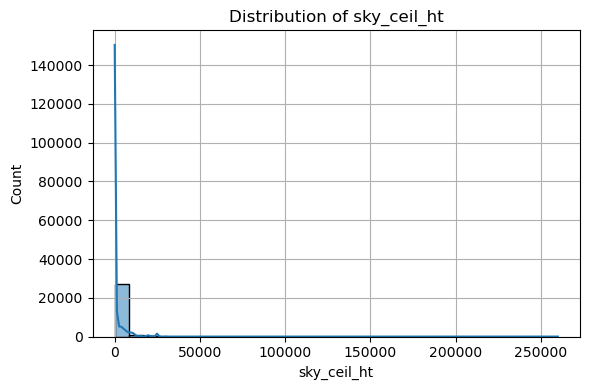

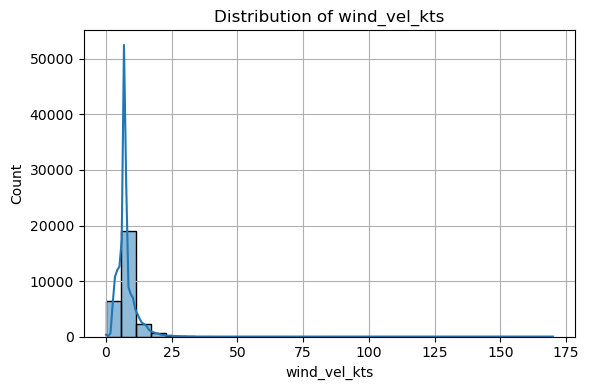

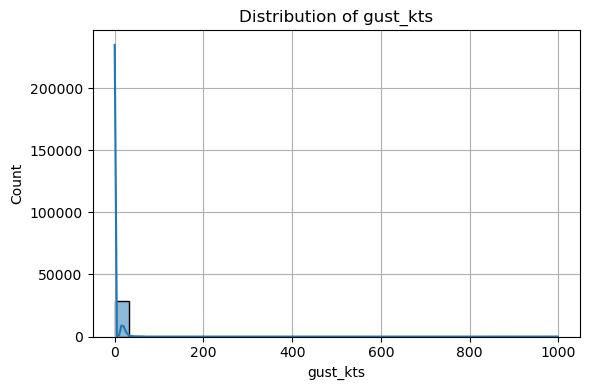

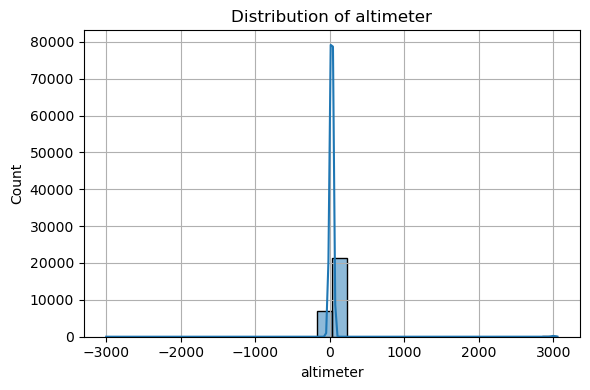

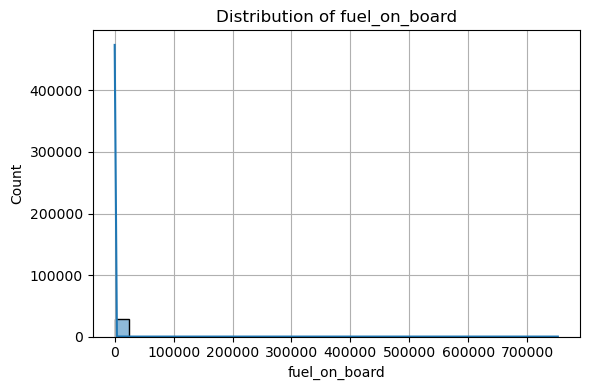

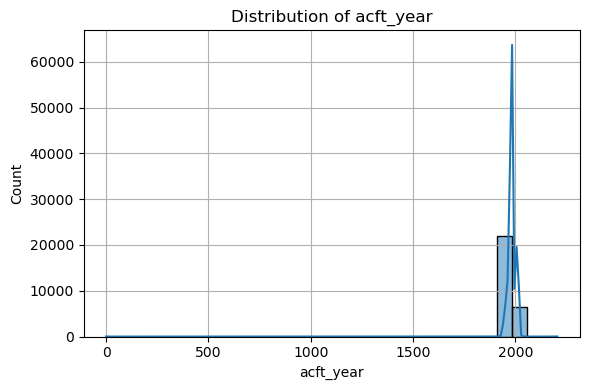

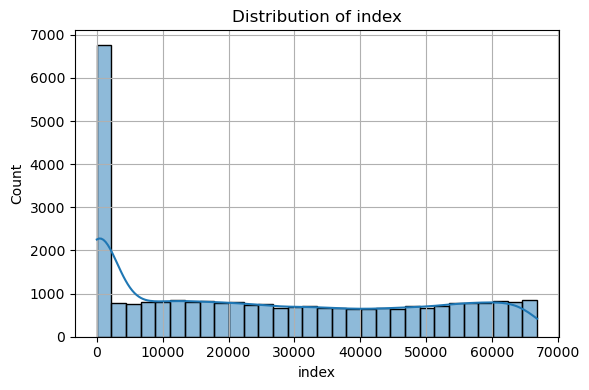

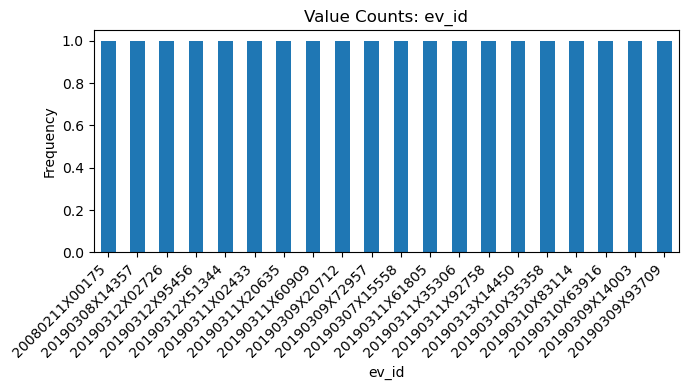

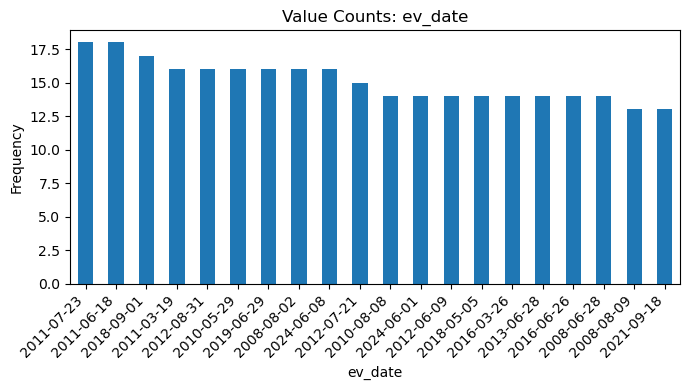

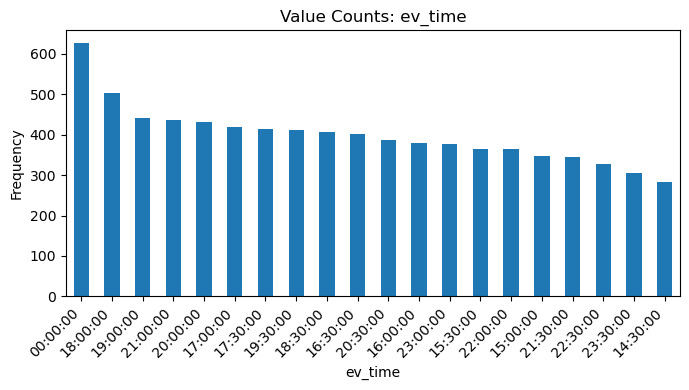

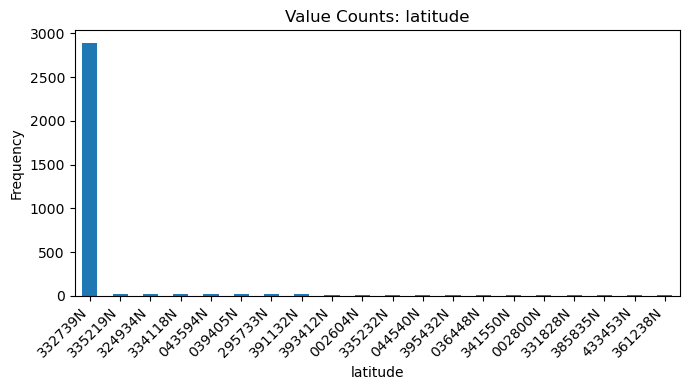

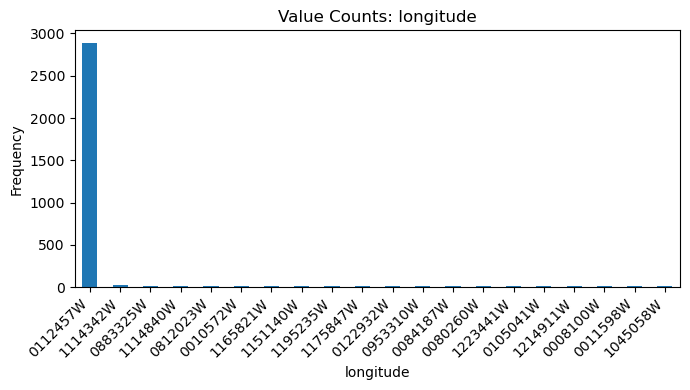

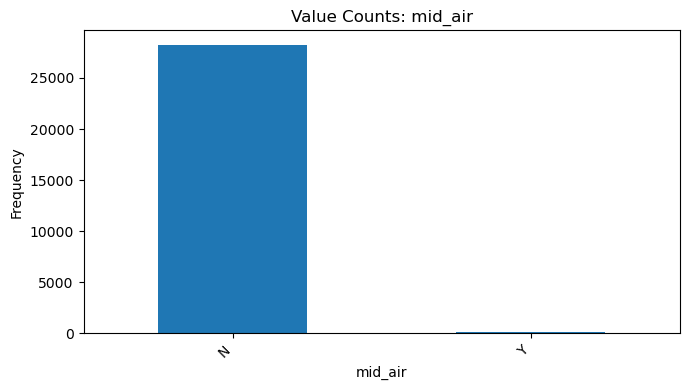

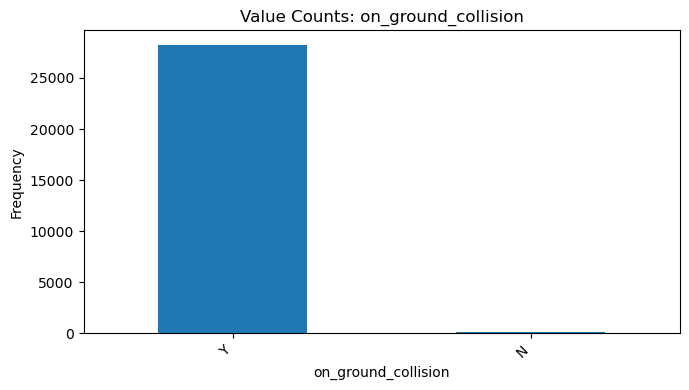

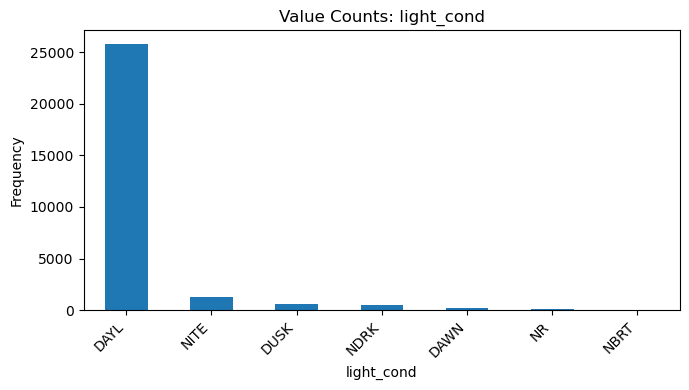

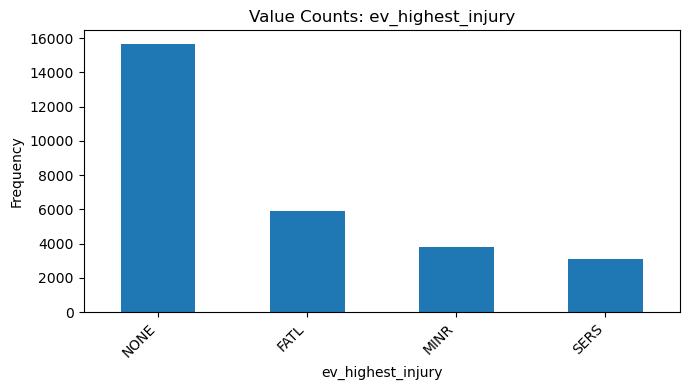

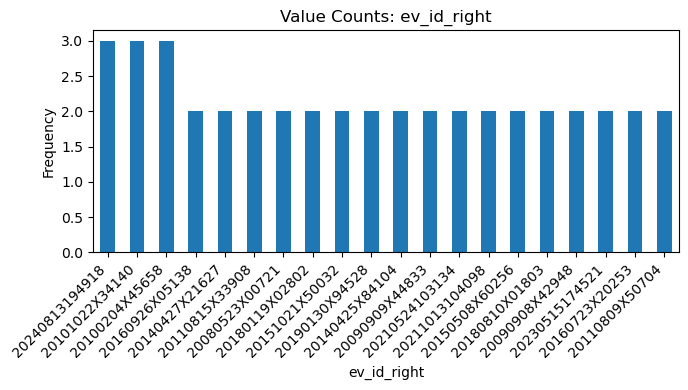

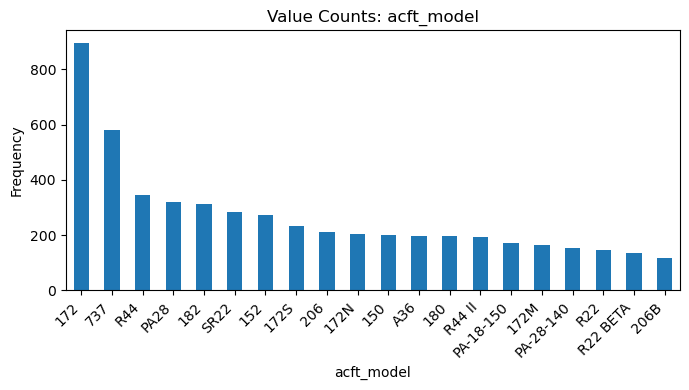

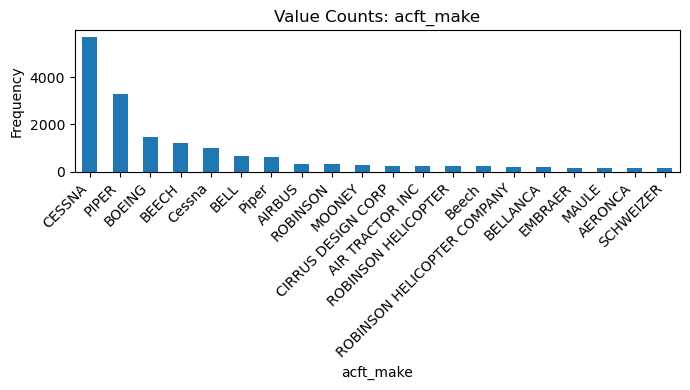

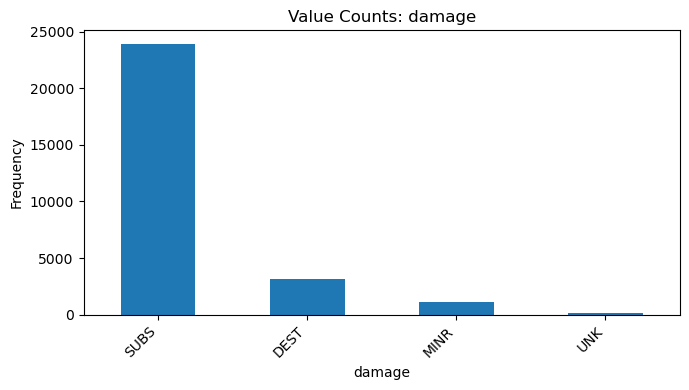

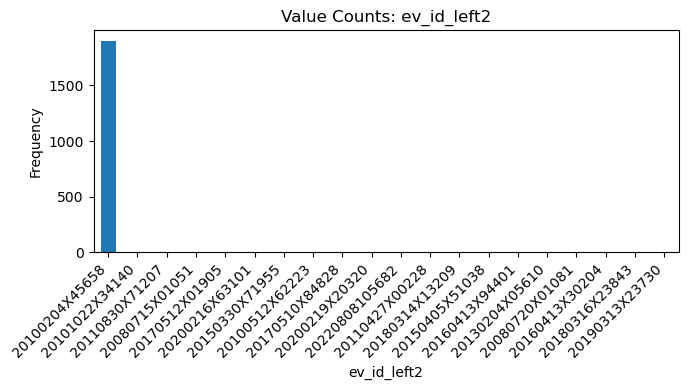

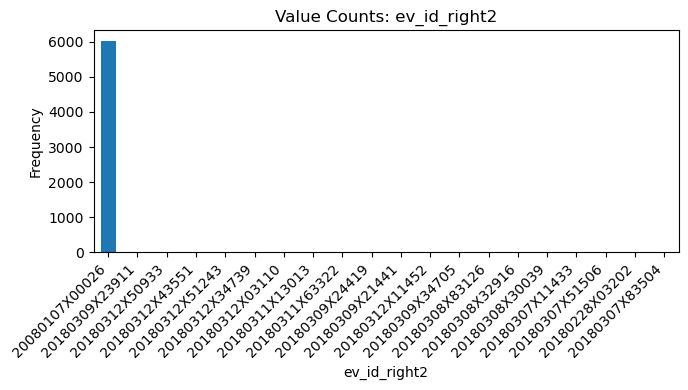

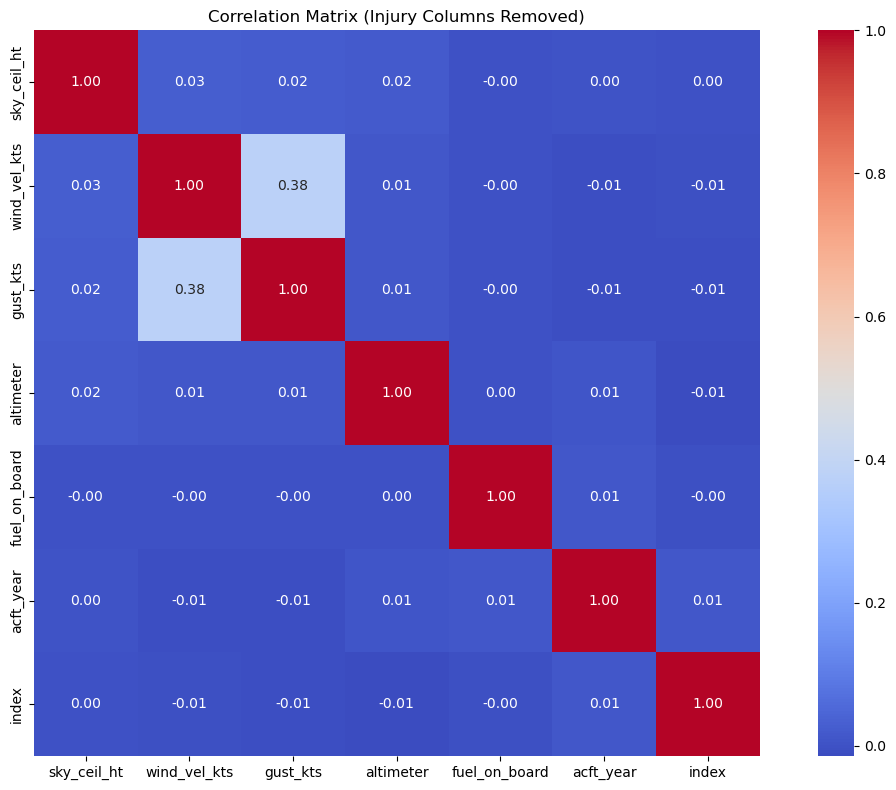

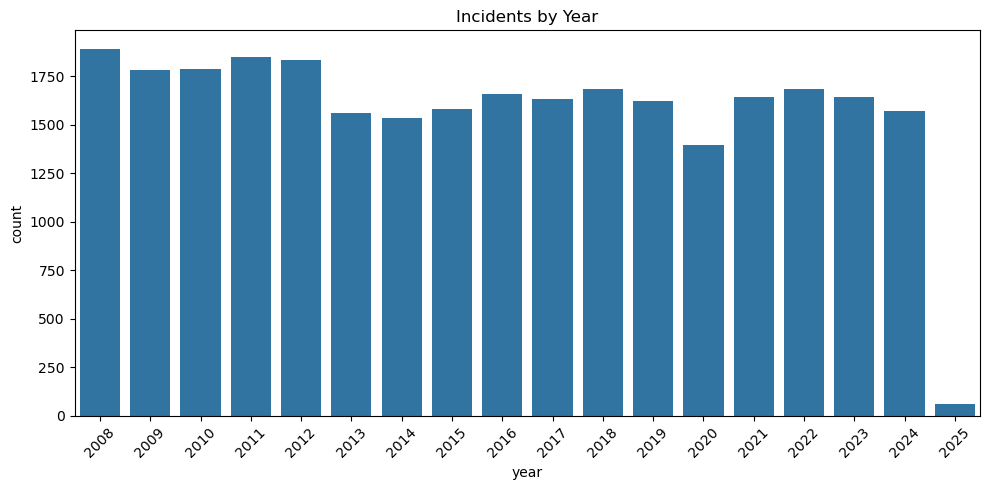

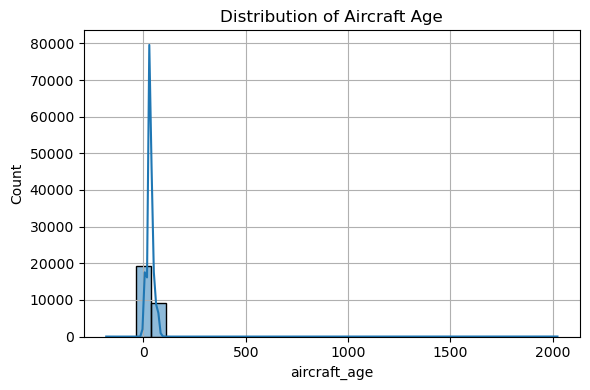

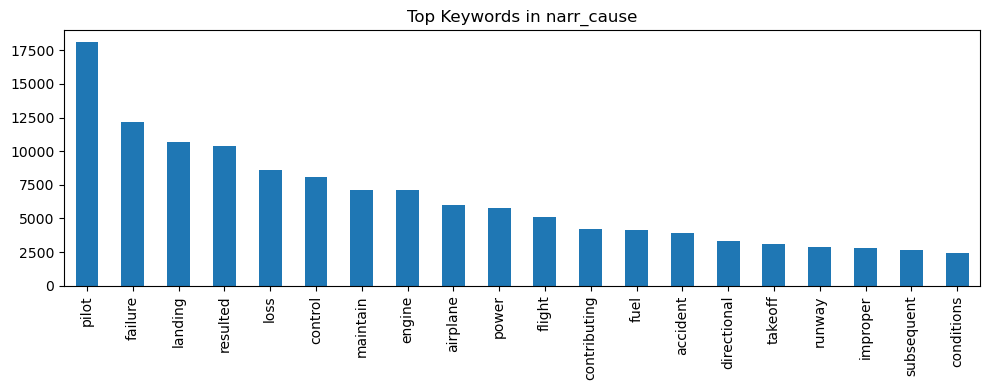

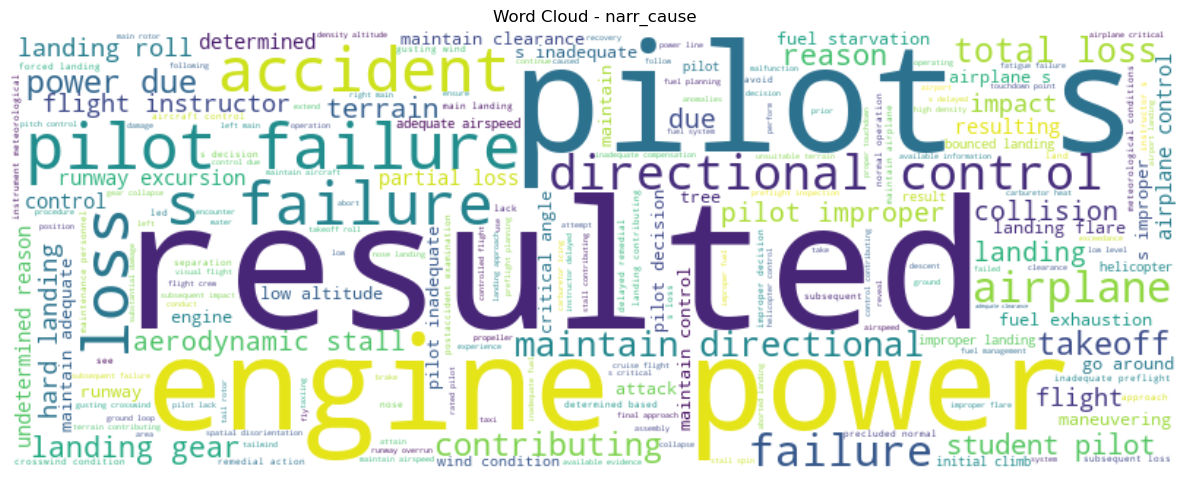

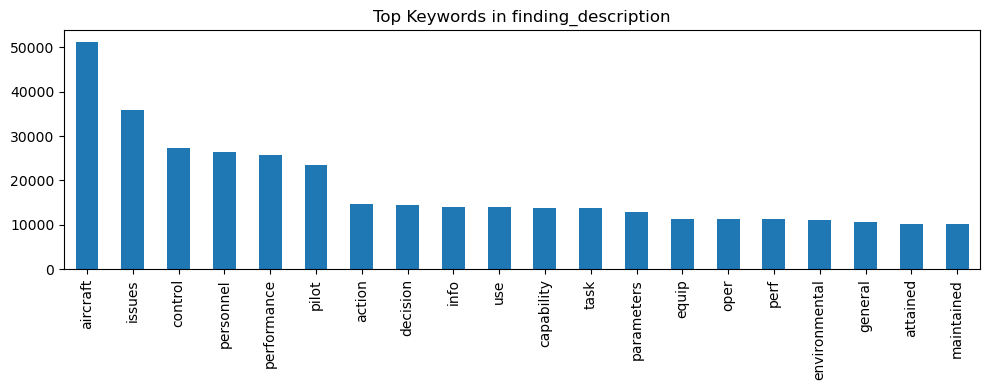

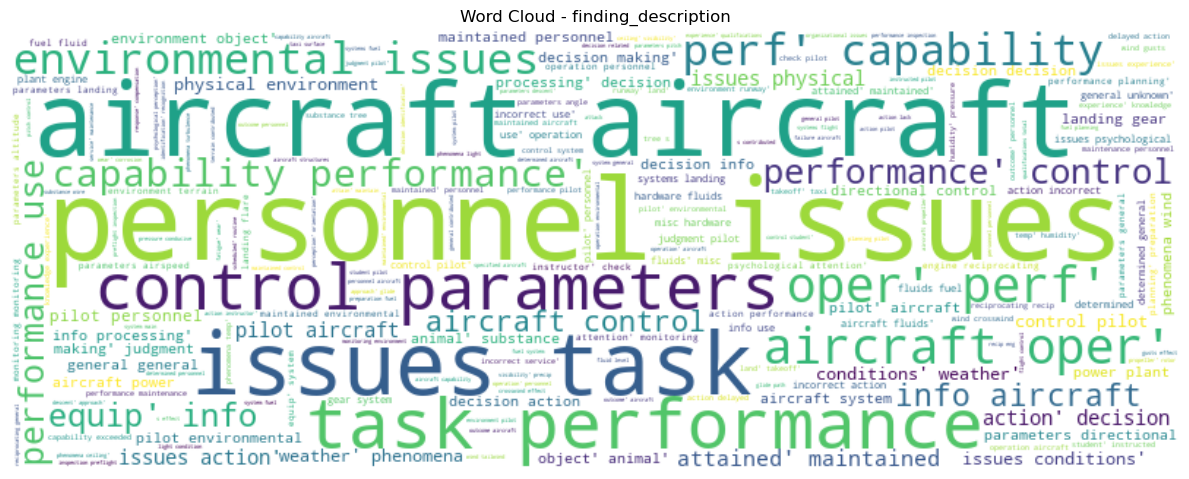

In [70]:
# Exploratory Analysis of Post_2008 dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud
import re

# Load the dataset (use exact filename if different)
post_2008_dataset = pd.read_csv("Dataset_Post_2008.csv")

# preprocessing function to perform NLP
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip().lower()

# Applying the function for two columns with long descriptions
post_2008_dataset['narr_cause'] = post_2008_dataset['narr_cause'].astype(str).apply(preprocess_text)
post_2008_dataset['finding_description'] = post_2008_dataset['finding_description'].astype(str).apply(preprocess_text)


# Printing basic info 
print("Shape:", post_2008_dataset.shape)
print("Data Types:\n", post_2008_dataset.dtypes)
print("Missing Values:\n", post_2008_dataset.isnull().sum())

# Removing injury columns from analysis as they are all zeros
injury_columns = ['wx_int_precip','FATL', 'MINR', 'NONE', 'SERS', 'TOTL']
post_2008_dataset = post_2008_dataset.drop(columns=injury_columns, errors='ignore')

#  printing Descriptive stats for valid numeric columns
numeric_columns = post_2008_dataset.select_dtypes(include=['int64', 'float64']).columns
print("Descriptive Statistics (No Injury Columns):\n")
print(post_2008_dataset[numeric_columns].describe())

# Distribution plots
for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(post_2008_dataset[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# BAR PLOTS for categorical columns
categorical_columns = [col for col in post_2008_dataset.select_dtypes(include='object').columns
                    if col not in ['narr_cause', 'finding_description']]

for col in categorical_columns:
    plt.figure(figsize=(7, 4))
    post_2008_dataset[col].value_counts(dropna=False).head(20).plot(kind='bar')
    plt.title(f"Value Counts: {col}")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(post_2008_dataset[numeric_columns].corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix (Injury Columns Removed)")
plt.tight_layout()
plt.show()

# plotting number of incidents by year
post_2008_dataset['ev_date'] = pd.to_datetime(post_2008_dataset['ev_date'], errors='coerce')
post_2008_dataset['year'] = post_2008_dataset['ev_date'].dt.year

plt.figure(figsize=(10, 5))
sns.countplot(data=post_2008_dataset, x='year', order=sorted(post_2008_dataset['year'].dropna().unique()))
plt.xticks(rotation=45)
plt.title("Incidents by Year")
plt.tight_layout()
plt.show()

# Calculate aircraft age if acft_year
if 'acft_year' in post_2008_dataset.columns:
    post_2008_dataset['aircraft_age'] = post_2008_dataset['year'] - post_2008_dataset['acft_year']

plt.figure(figsize=(6, 4))
sns.histplot(post_2008_dataset['aircraft_age'], bins=30, kde=True)
plt.title("Distribution of Aircraft Age")
plt.grid(True)
plt.tight_layout()
plt.show()


# applying NLP on narr_cause
combined_text_narr = ' '.join(post_2008_dataset['narr_cause'].dropna())
vectorizer_narr = CountVectorizer(stop_words='english', max_features=20)
narr_words = vectorizer_narr.fit_transform([combined_text_narr])
narr_freq = dict(zip(vectorizer_narr.get_feature_names_out(), narr_words.toarray()[0]))

pd.Series(narr_freq).sort_values(ascending=False).plot(kind='bar', figsize=(10,4), title="Top Keywords in narr_cause")
plt.tight_layout()
plt.show()

wordcloud_narr = WordCloud(width=800, height=300, background_color='white').generate(combined_text_narr)
plt.figure(figsize=(12, 5))
plt.imshow(wordcloud_narr, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - narr_cause")
plt.tight_layout()
plt.show()

# Applying NLP on finding_description
combined_text_find = ' '.join(post_2008_dataset['finding_description'].dropna())
vectorizer_find = CountVectorizer(stop_words='english', max_features=20)
find_words = vectorizer_find.fit_transform([combined_text_find])
find_freq = dict(zip(vectorizer_find.get_feature_names_out(), find_words.toarray()[0]))

pd.Series(find_freq).sort_values(ascending=False).plot(kind='bar', figsize=(10,4), title="Top Keywords in finding_description")
plt.tight_layout()
plt.show()

wordcloud_find = WordCloud(width=800, height=300, background_color='white').generate(combined_text_find)
plt.figure(figsize=(12, 5))
plt.imshow(wordcloud_find, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - finding_description")
plt.tight_layout()
plt.show()


Shape: (60868, 27)
Data Types:
 ev_id                       object
Occurrence_Code             object
Phase_of_Flight              int64
Altitude                    object
ev_date                     object
ev_time                     object
latitude                    object
longitude                   object
mid_air                     object
on_ground_collision         object
light_cond                  object
sky_ceil_ht                float64
wind_vel_kts               float64
gust_kts                   float64
altimeter                  float64
wx_int_precip              float64
ev_highest_injury           object
acft_model                  object
acft_make                   object
damage                      object
narr_cause                  object
FATL                         int64
MINR                         int64
NONE                         int64
SERS                         int64
TOTL                         int64
Phase_of_Flight_meaning     object
dtype: object
Missing V

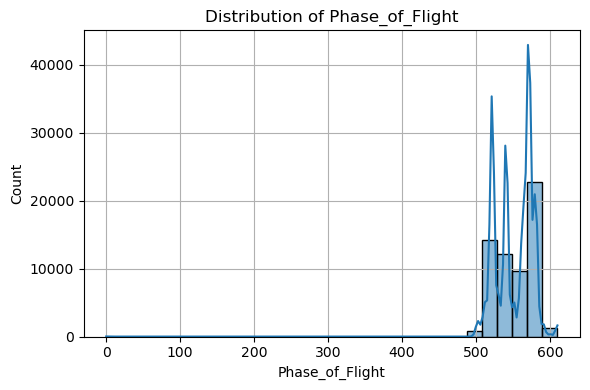

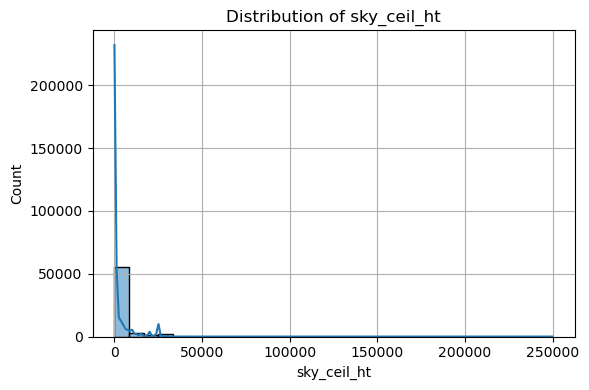

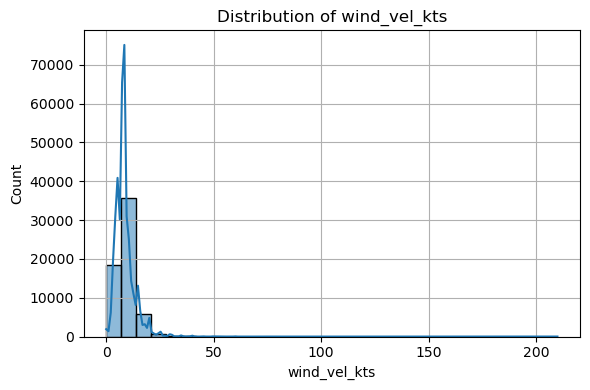

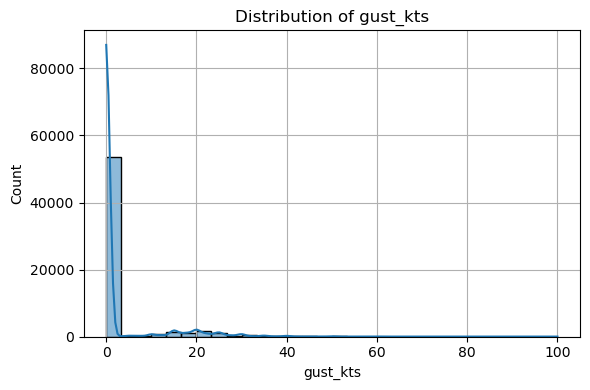

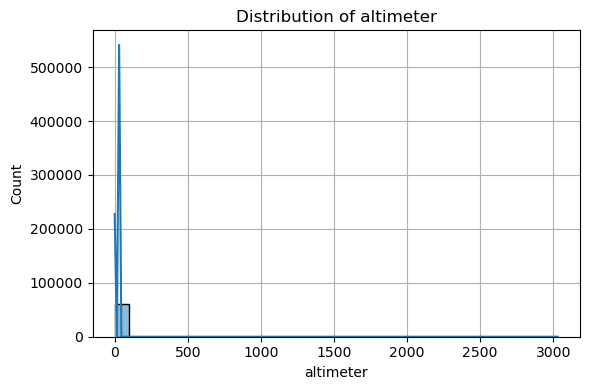

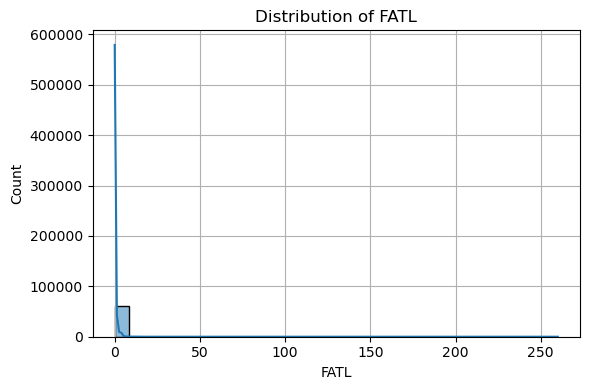

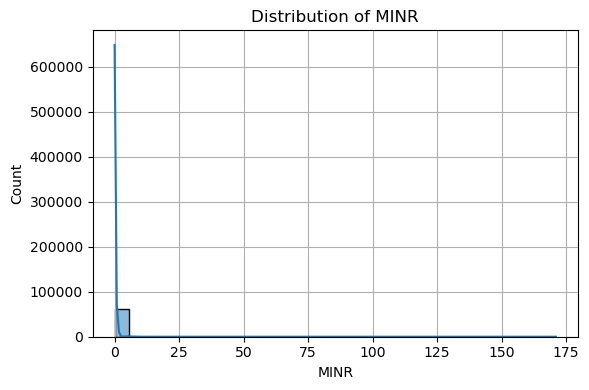

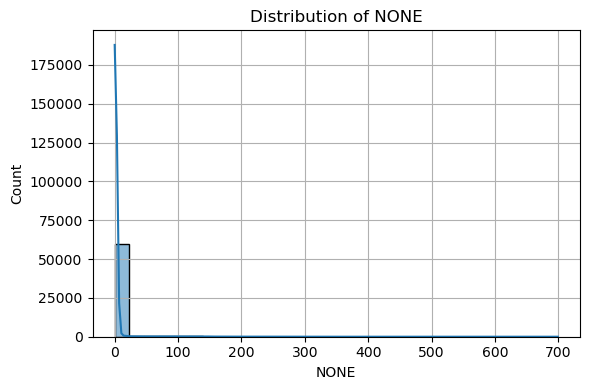

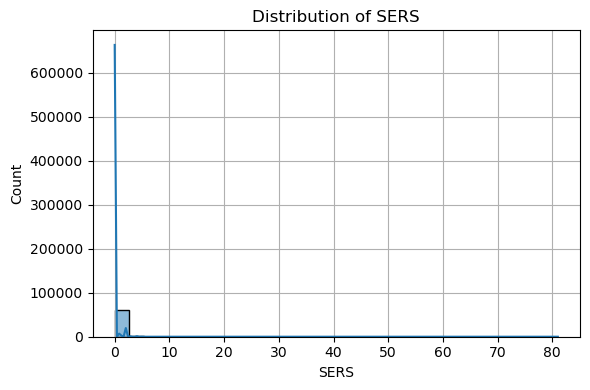

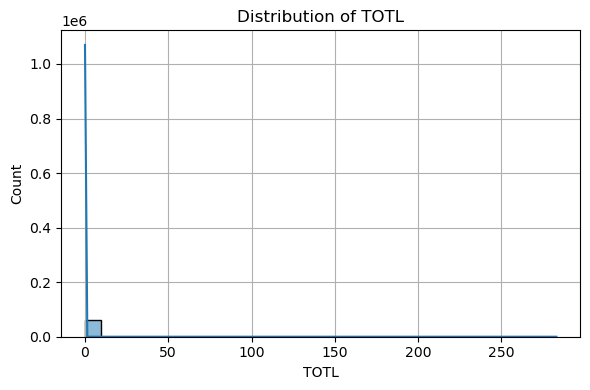

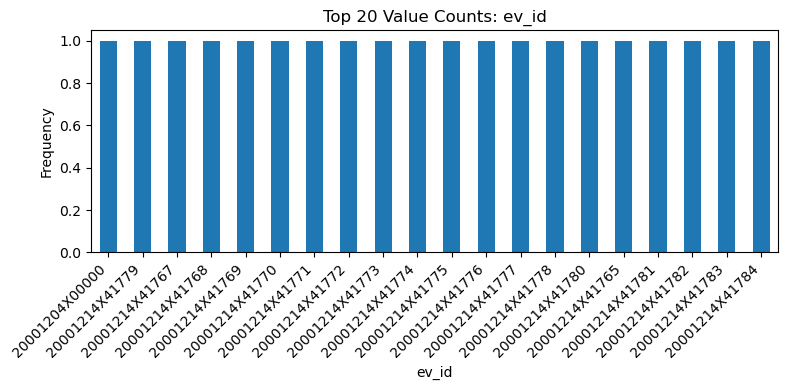

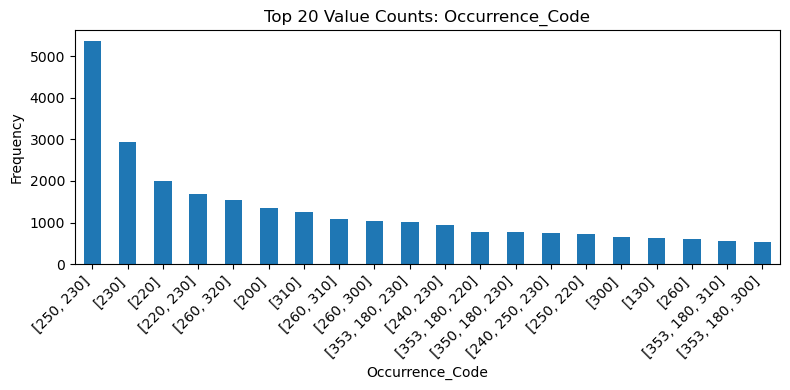

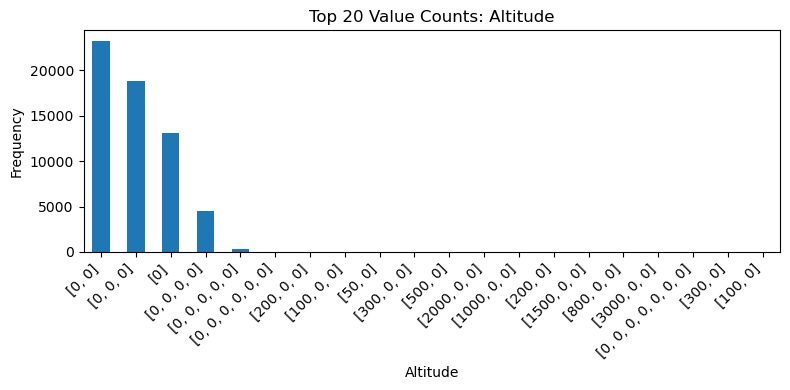

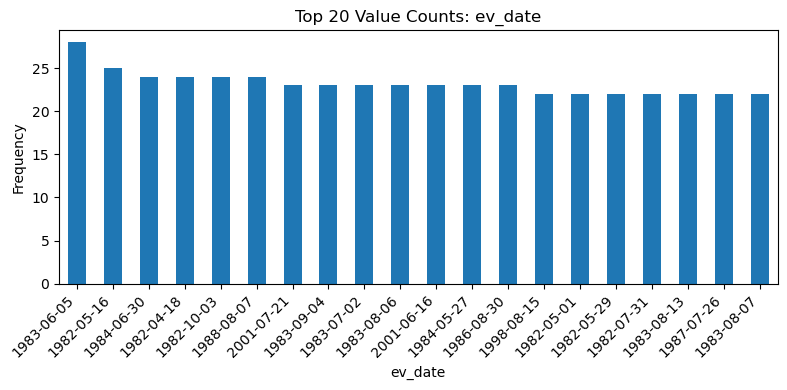

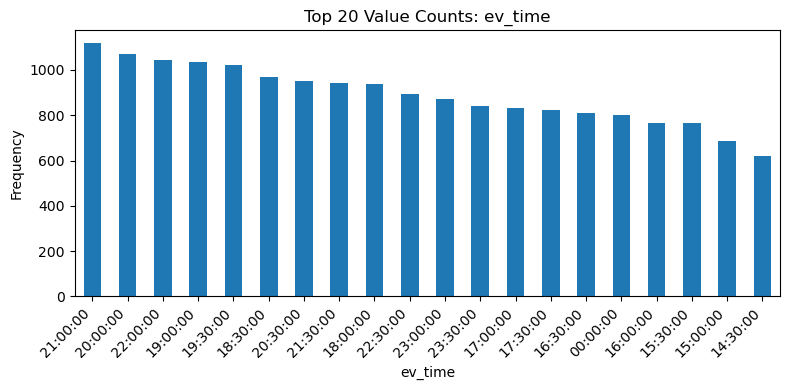

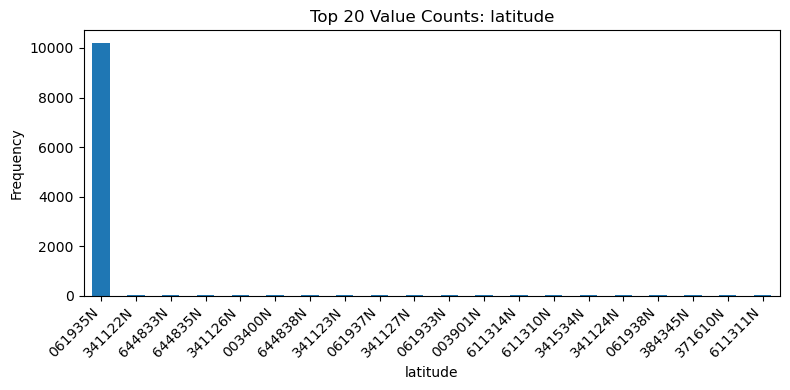

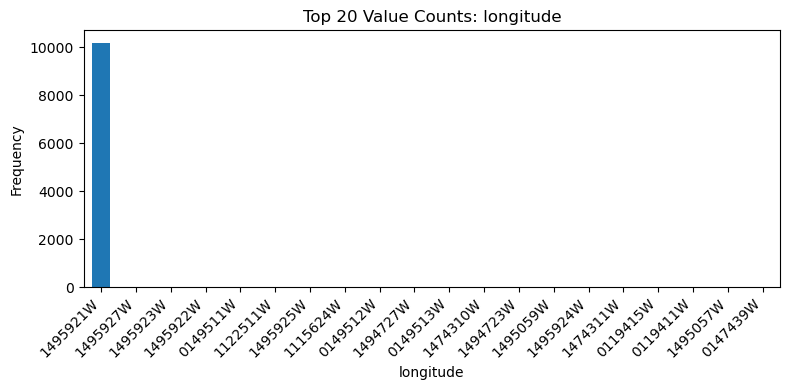

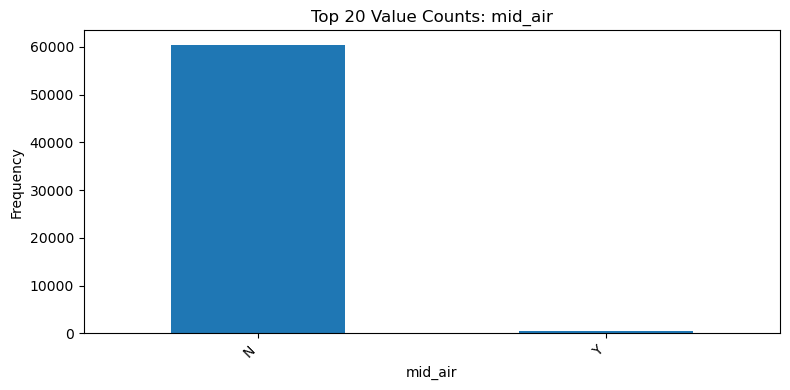

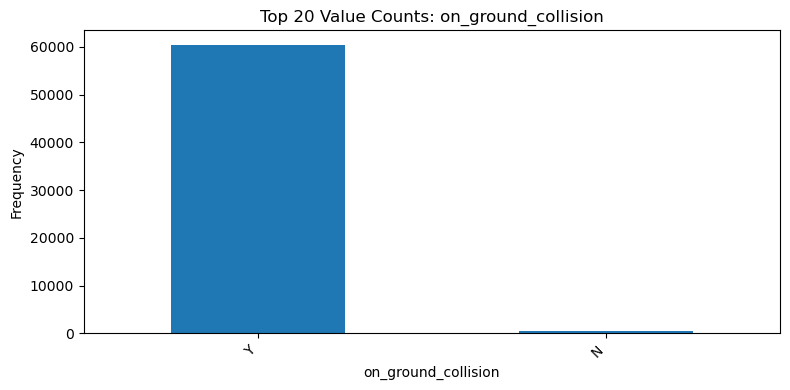

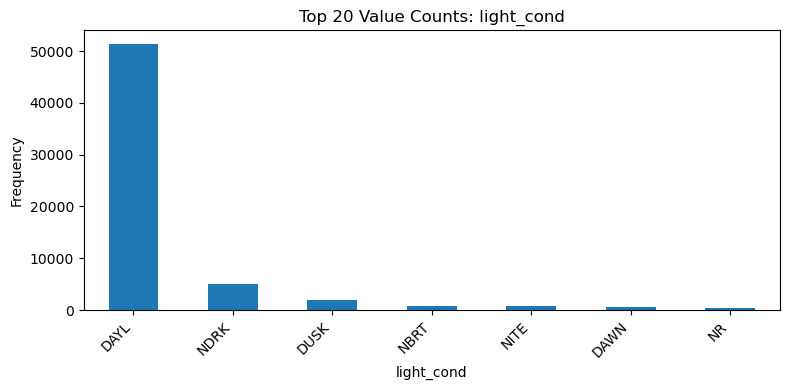

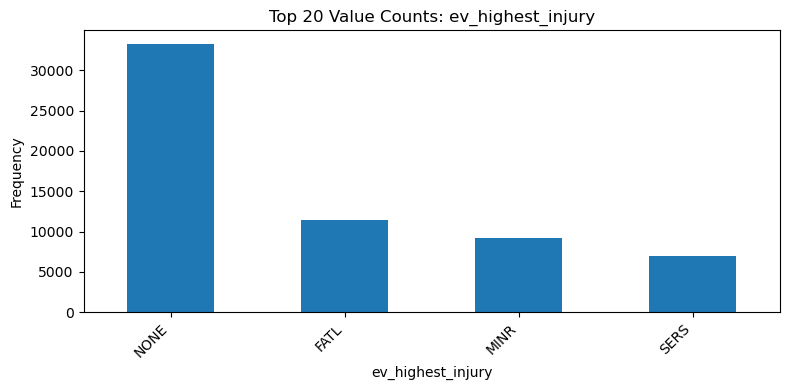

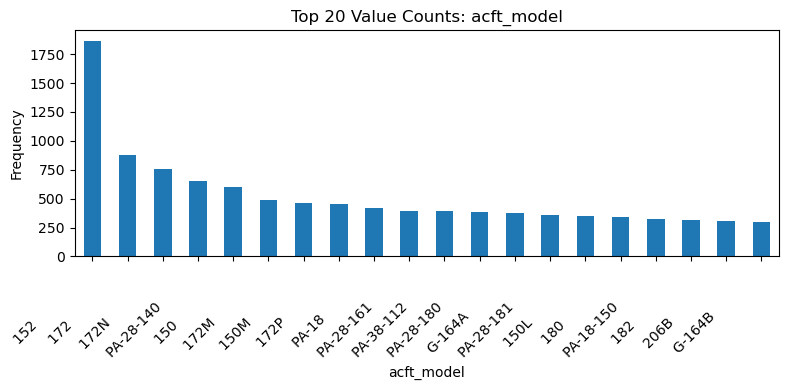

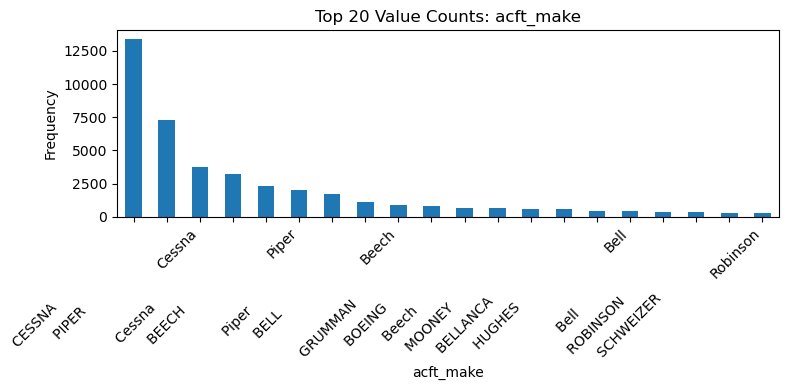

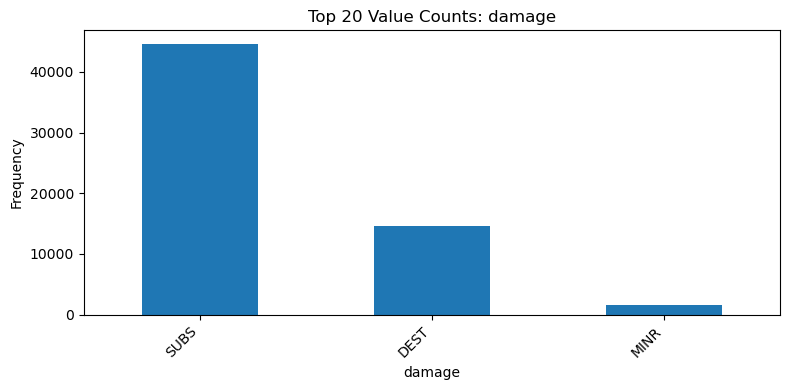

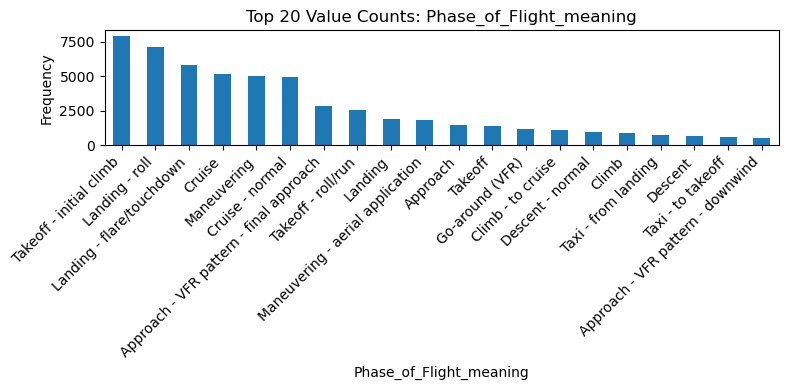

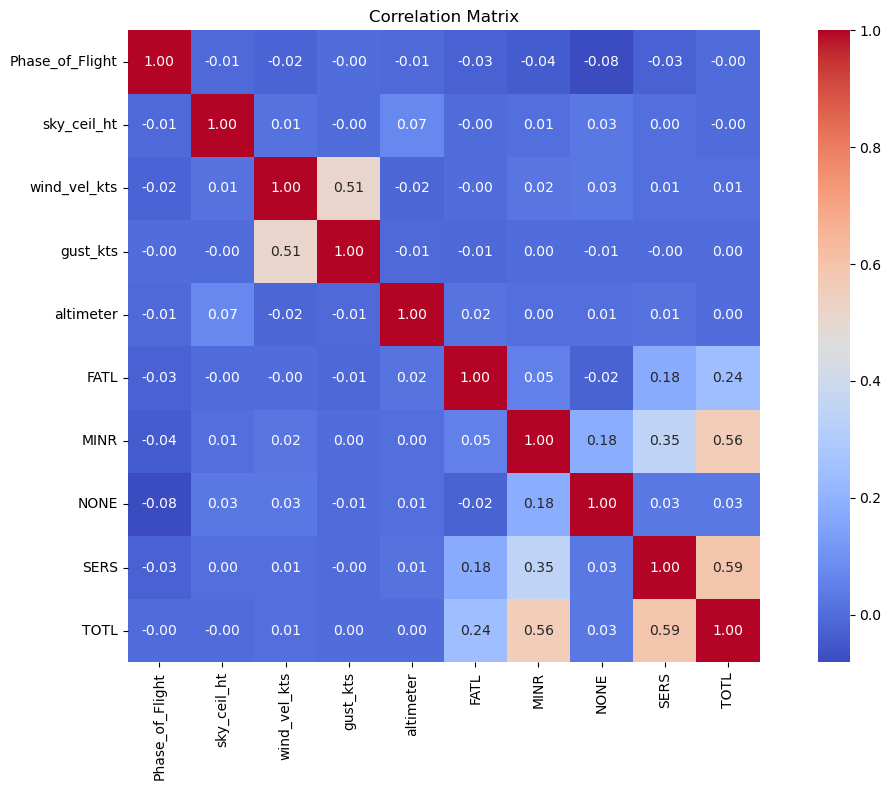

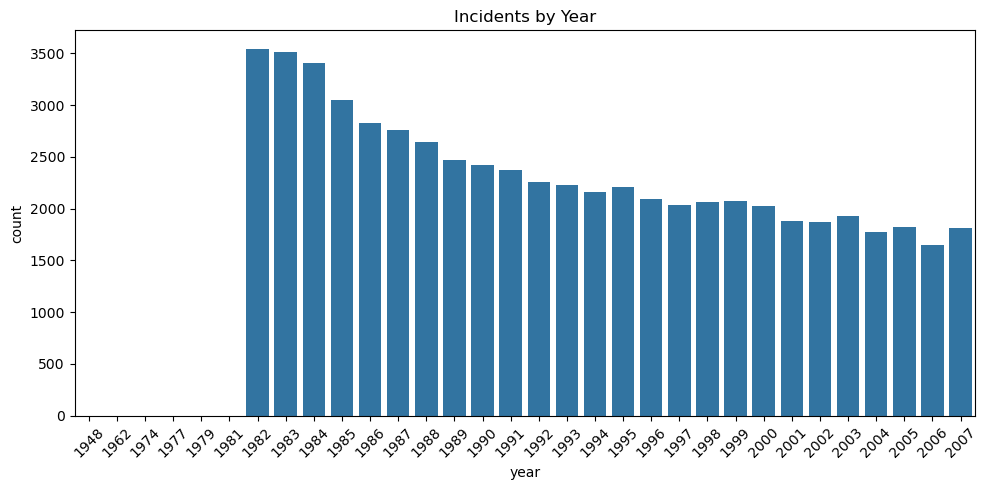

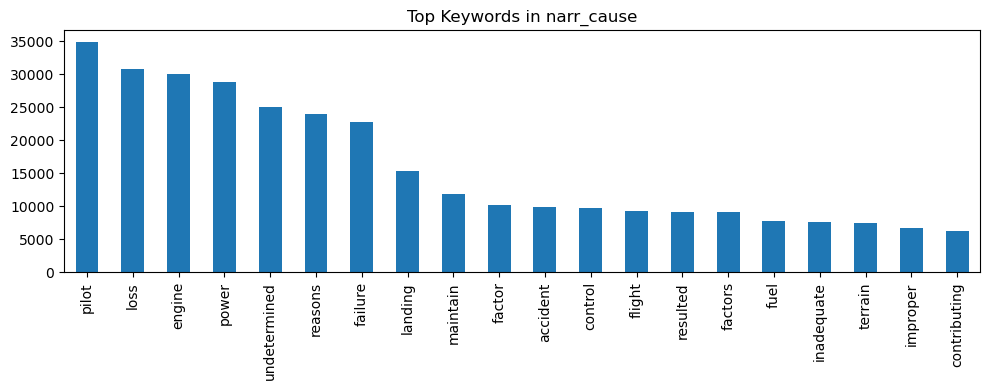

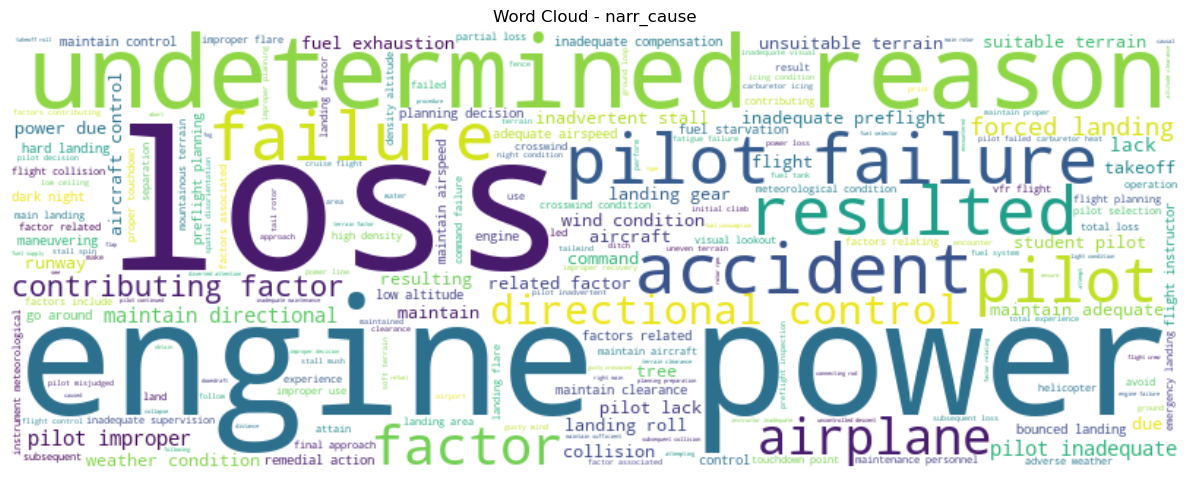

In [74]:
# Loading the dataset fo 1982_2008 data
dataset_1982_2008 = pd.read_csv("Dataset_1982_to_2008.csv")

# NLP text preprocessing function
def preprocess_text(text):
    if pd.isnull(text):
        return ""
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip().lower()

# Apply preprocessing to text columns
dataset_1982_2008['narr_cause'] = dataset_1982_2008['narr_cause'].astype(str).apply(preprocess_text)

# Overview of dataset
print("Shape:", dataset_1982_2008.shape)
print("Data Types:\n", dataset_1982_2008.dtypes)
print("Missing Values:\n", dataset_1982_2008.isnull().sum())

# Removing empty columns from analysis as they are all zeros
injury_columns = ['wx_int_precip']
dataset_1982_2008 = dataset_1982_2008.drop(columns=injury_columns, errors='ignore')

# printing Descriptive statistics
numeric_columns = dataset_1982_2008.select_dtypes(include=['int64', 'float64']).columns
print(" Descriptive Statistics:\n")
print(dataset_1982_2008[numeric_columns].describe())

# distribution plots for numerical columns
for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(dataset_1982_2008[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Bar plots for categorical values
categorical_columns = [col for col in dataset_1982_2008.select_dtypes(include='object').columns
    if col not in ['narr_cause']]

for col in categorical_columns:
    plt.figure(figsize=(8, 4))
    dataset_1982_2008[col].value_counts(dropna=False).head(20).plot(kind='bar')
    plt.title(f"Top 20 Value Counts: {col}")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

#  Correlation matrix 
plt.figure(figsize=(12, 8))
sns.heatmap(dataset_1982_2008[numeric_columns].corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

# Plotting number of Incidents by year
if 'ev_date' in dataset_1982_2008.columns:
    dataset_1982_2008['ev_date'] = pd.to_datetime(dataset_1982_2008['ev_date'], errors='coerce')
    dataset_1982_2008['year'] = dataset_1982_2008['ev_date'].dt.year

    plt.figure(figsize=(10, 5))
    sns.countplot(dataset_1982_2008, x='year', order=sorted(dataset_1982_2008['year'].dropna().unique()))
    plt.xticks(rotation=45)
    plt.title("Incidents by Year")
    plt.tight_layout()
    plt.show()

# Applying NLP for narr_cause column
combined_text_narr = ' '.join(dataset_1982_2008['narr_cause'].dropna())
vectorizer_narr = CountVectorizer(stop_words='english', max_features=20)
narr_words = vectorizer_narr.fit_transform([combined_text_narr])
narr_freq = dict(zip(vectorizer_narr.get_feature_names_out(), narr_words.toarray()[0]))

pd.Series(narr_freq).sort_values(ascending=False).plot(kind='bar', figsize=(10,4), title="Top Keywords in narr_cause")
plt.tight_layout()
plt.show()

wordcloud_narr = WordCloud(width=800, height=300, background_color='white').generate(combined_text_narr)
plt.figure(figsize=(12, 5))
plt.imshow(wordcloud_narr, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud - narr_cause")
plt.tight_layout()
plt.show()

Shape: (57538, 30)
Data Types:
 ev_id                       int64
RecNum_left                 int64
DATE_OCCURRENCE            object
TIME_OCCUR                 object
LOCATION                   object
LIGHT_COND                 object
ALT_OF_OCC                float64
ACFT_MODEL                 object
ACFT_MAKE                  object
ACFT_ADAMG                 object
ACCIDENT_TYPE1             object
ACCIDENT_TYPE2             object
GRAND_TOTAL_FATAL           int64
GRAND_TOTAL_SERIOUS         int64
GRAND_TOTAL_MINOR           int64
GRAND_TOTAL_NONE            int64
RecNum_right                int64
CEILING                   float64
WIND_VELOCITY             float64
PRECIPITATION              object
CAUSE                      object
RecNum                      int64
Altitude                  float64
PhaseOfFlight              object
LIGHT_COND_meaning         object
ACFT_ADAMG_meaning         object
PRECIPITATION_meaning      object
ACCIDENT_TYPE1_meaning     object
ACCIDENT_TYPE2_m

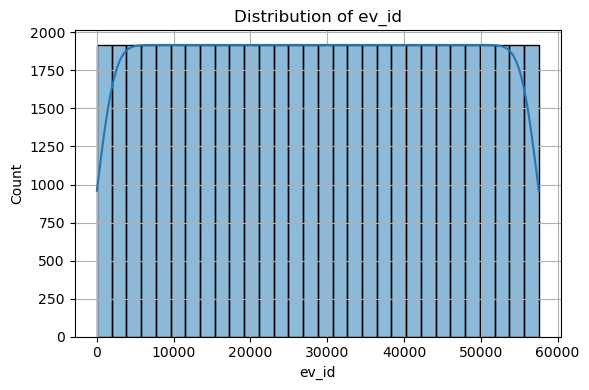

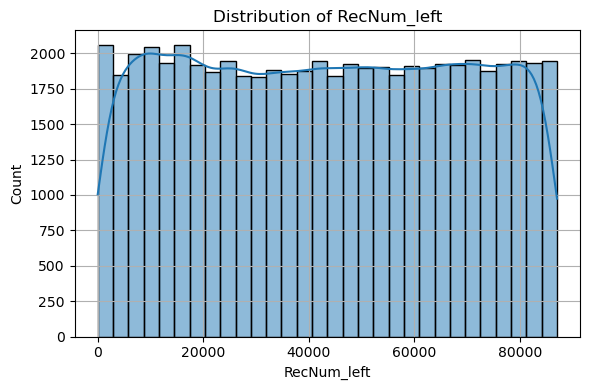

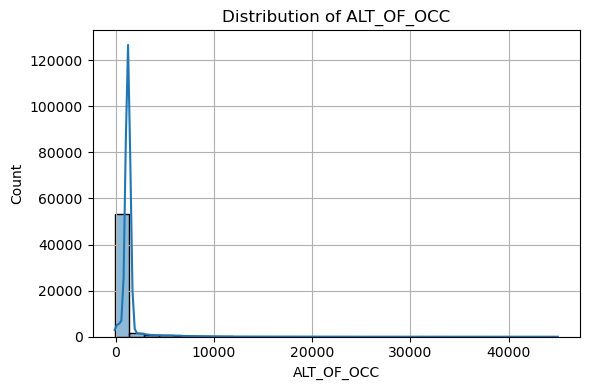

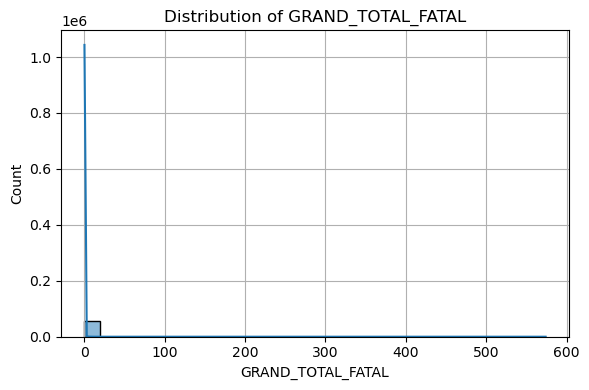

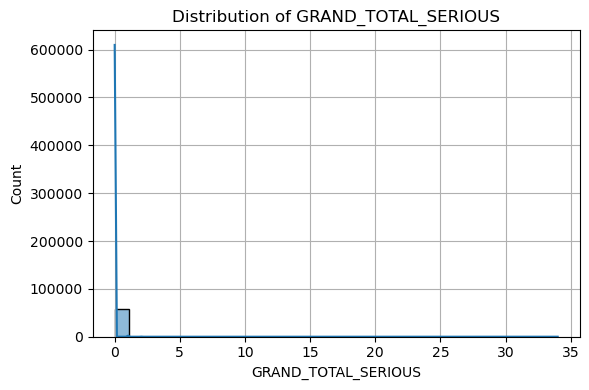

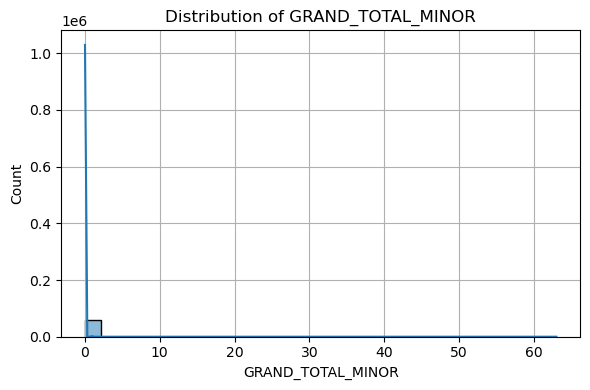

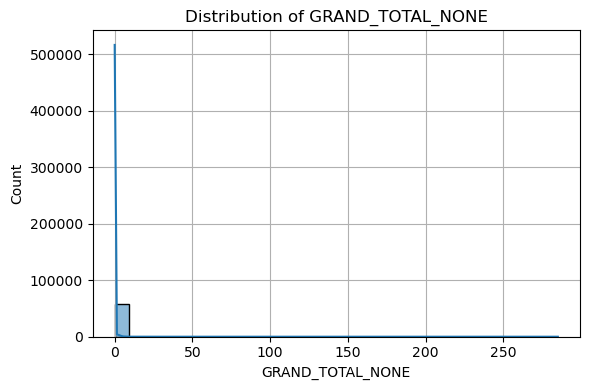

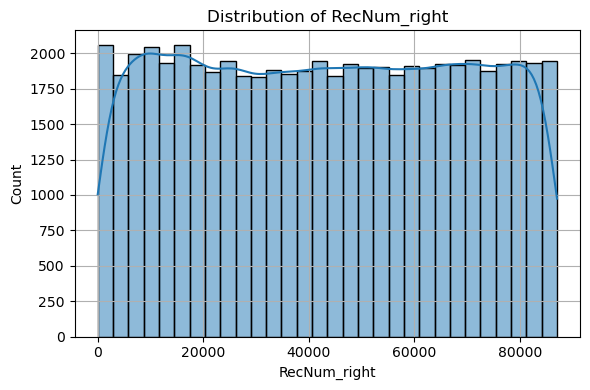

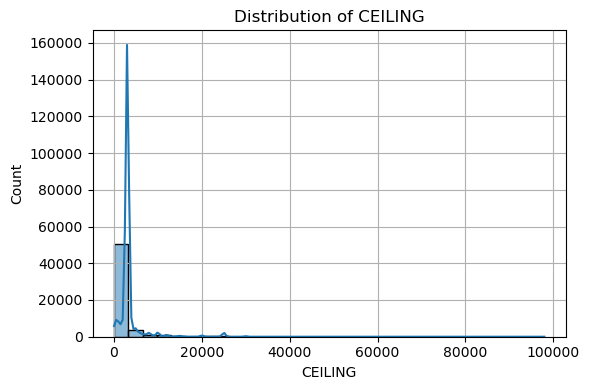

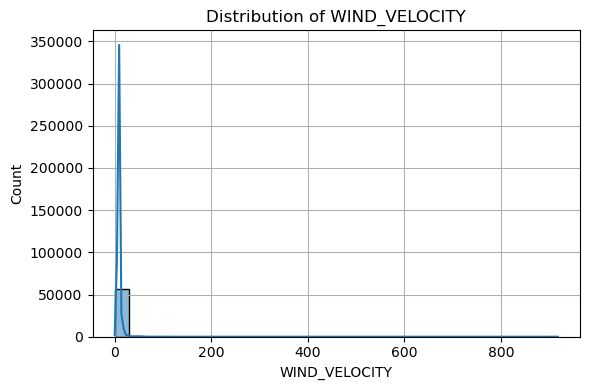

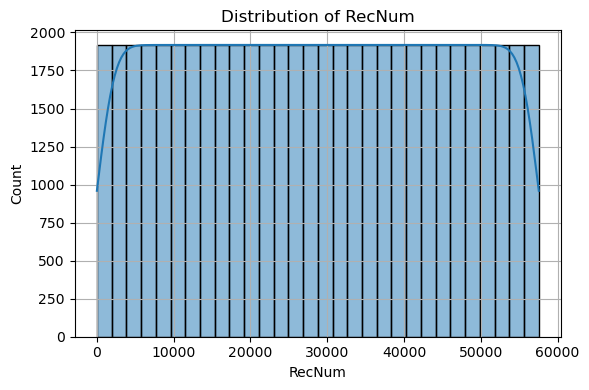

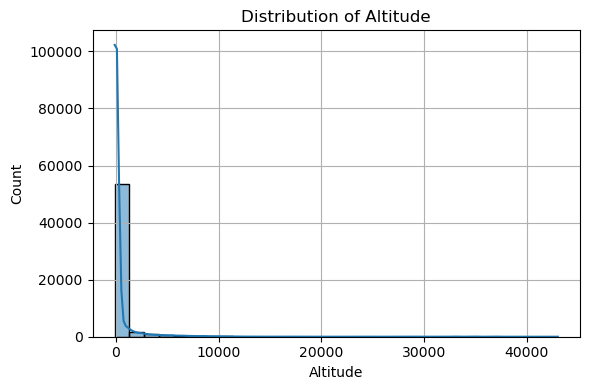

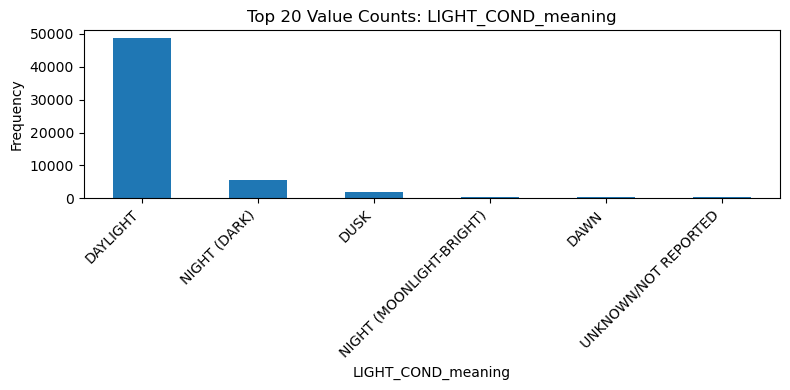

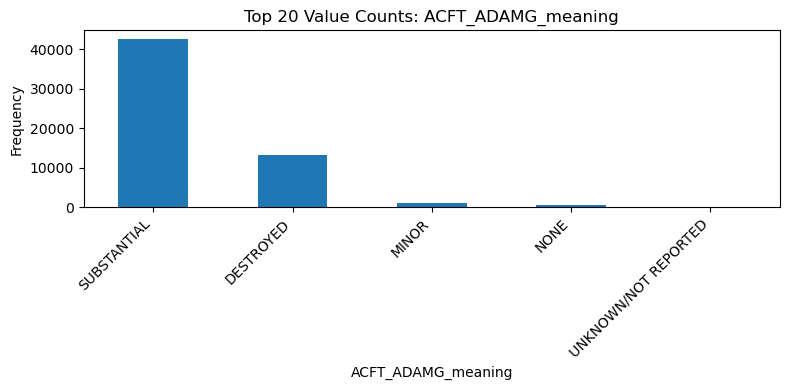

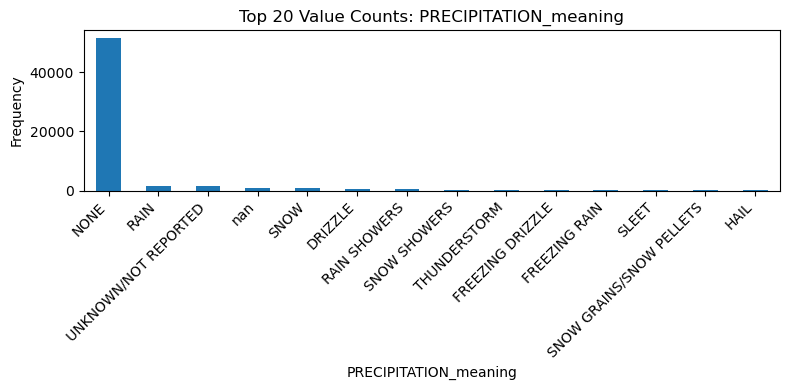

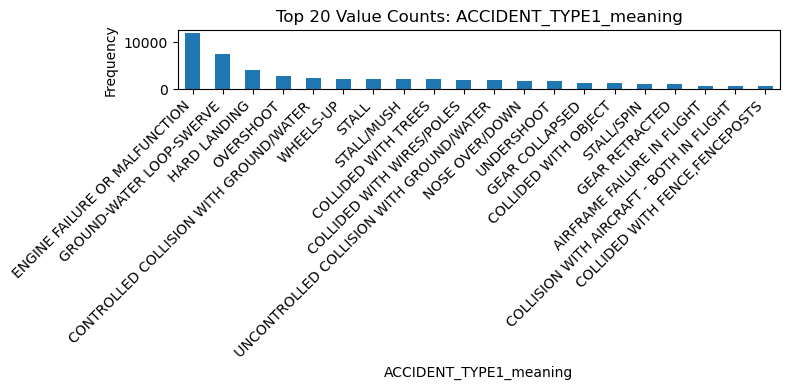

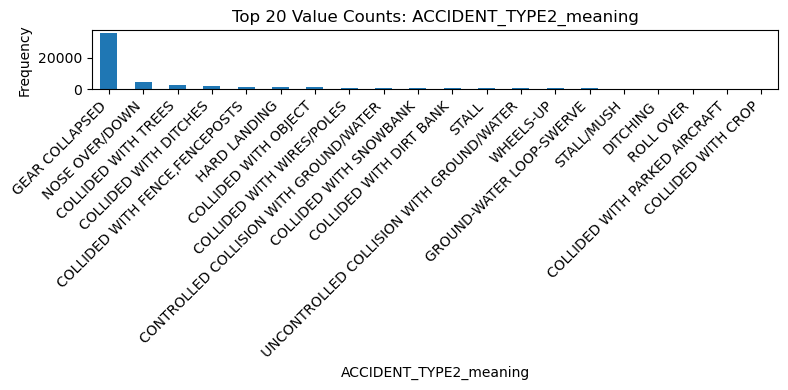

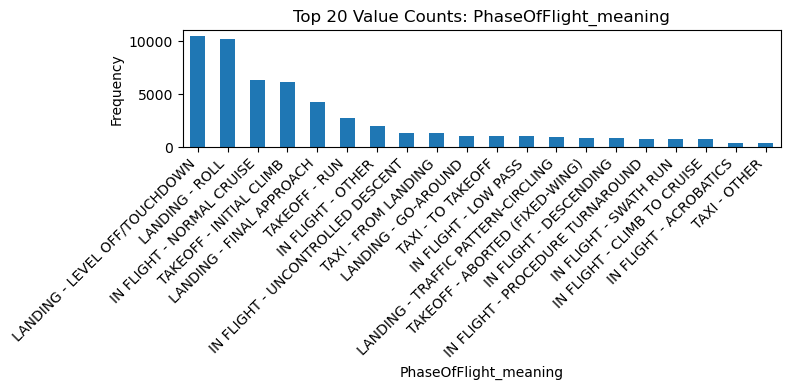

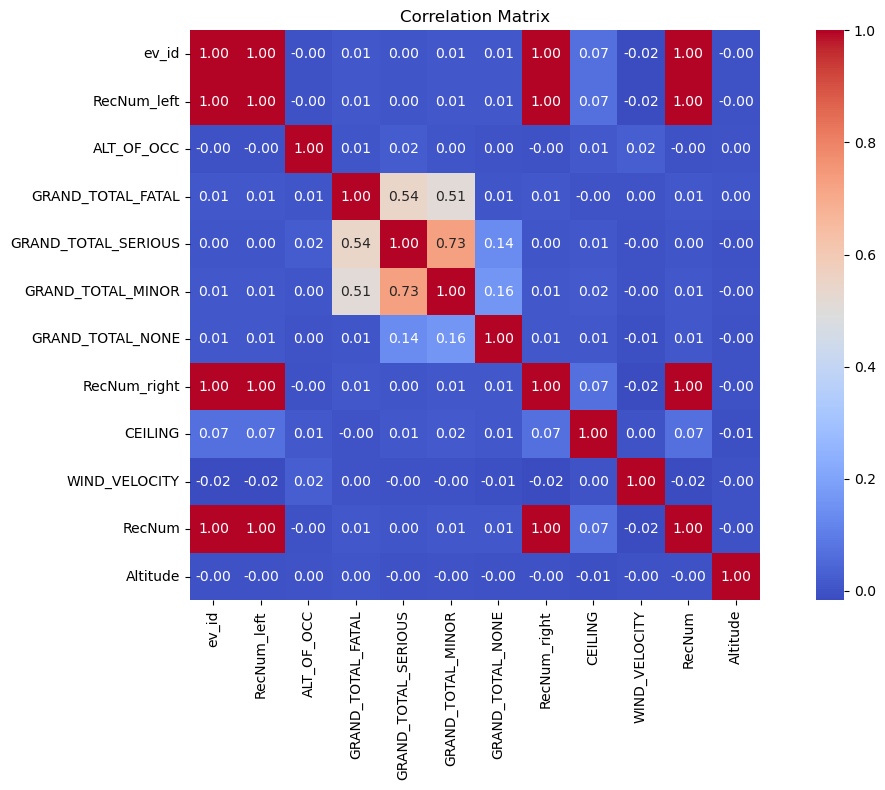

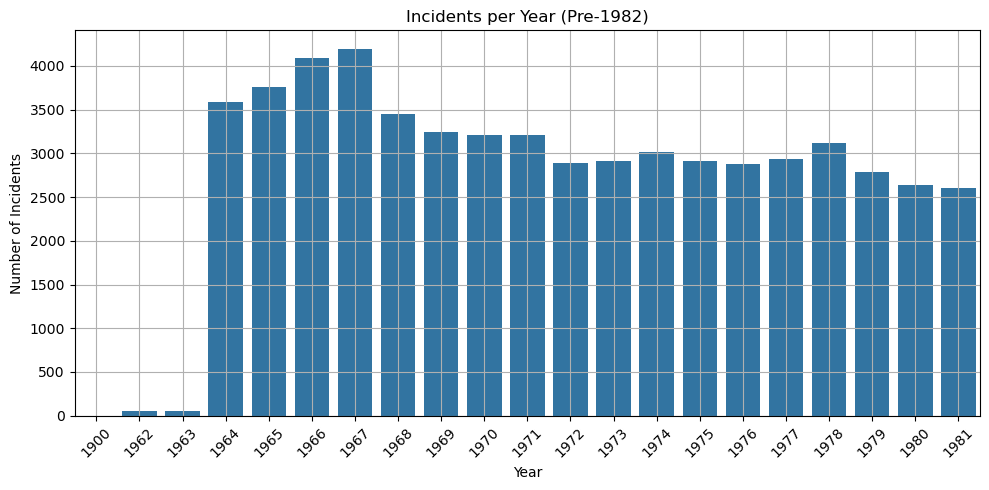

In [76]:
# Loading dataset
pre_1982_dataset = pd.read_csv("Dataset_Pre_1982.csv")

#  Overview of dataset
print("Shape:", pre_1982_dataset.shape)
print("Data Types:\n", pre_1982_dataset.dtypes)
print("Missing Values:\n", pre_1982_dataset.isnull().sum())

# Descriptive stats for numerics
numeric_columns = pre_1982_dataset.select_dtypes(include=['int64', 'float64']).columns
print("Descriptive Statistics:\n")
print(pre_1982_dataset[numeric_columns].describe())

# Histograms for numeric columns 
for col in numeric_columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(pre_1982_dataset[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Bar plots for categorical columns 
categorical_columns = pre_1982_dataset.select_dtypes(include='object').columns
decoded_columns = [col for col in categorical_columns if col.endswith('_meaning')]

for col in decoded_columns:
    plt.figure(figsize=(8, 4))
    pre_1982_dataset[col].value_counts(dropna=False).head(20).plot(kind='bar')
    plt.title(f"Top 20 Value Counts: {col}")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Correlation heatmap 
if not numeric_columns.empty:
    plt.figure(figsize=(12, 8))
    sns.heatmap(pre_1982_dataset[numeric_columns].corr(), annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Correlation Matrix")
    plt.tight_layout()
    plt.show()
    
# plotting yearly trends of incidents
pre_1982_dataset['DATE_OCCURRENCE'] = pd.to_datetime(pre_1982_dataset['DATE_OCCURRENCE'], errors='coerce')
pre_1982_dataset['year'] = pre_1982_dataset['DATE_OCCURRENCE'].dt.year

plt.figure(figsize=(10, 5))
sns.countplot(data=pre_1982_dataset, x='year', order=sorted(pre_1982_dataset['year'].dropna().unique()))
plt.title("Incidents per Year (Pre-1982)")
plt.xlabel("Year")
plt.ylabel("Number of Incidents")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [78]:
import pandas as pd
# Loading final cleaned and decoded datasets
post_2008 = pd.read_csv("Dataset_Post_2008.csv")
mid_1982_2008 = pd.read_csv("Dataset_1982_to_2008.csv")
pre_1982 = pd.read_csv("Dataset_Pre_1982.csv")

# Adding source column
post_2008['source'] = 'Post-2008'
mid_1982_2008['source'] = '1982-2008'
pre_1982['source'] = 'Pre-1982'

# Renaming columns to format across all datasets
post_2008.rename(columns={
    'ev_date': 'event_date', 'ev_time': 'event_time',
    'light_cond': 'lighting_condition',
    'sky_ceil_ht': 'sky_ceiling_height',
    'wind_vel_kts': 'wind_velocity',
    'gust_kts': 'gusts',
    'altimeter': 'altimeter_setting',
    'fuel_on_board': 'fuel_on_board',
    'ev_highest_injury': 'highest_injury',
    'narr_cause': 'narrative_cause',
    'finding_description': 'finding_description',
    'damage': 'damage',
    'latitude': 'latitude',
    'longitude': 'longitude',
    'acft_model': 'acft_model',
    'acft_make': 'acft_make',
    'PhaseOfFlight': 'flight_phase',
    'Phase_of_Flight': 'flight_phase'
}, inplace=True)

mid_1982_2008.rename(columns={
    'ev_date': 'event_date', 'ev_time': 'event_time',
    'light_cond': 'lighting_condition',
    'sky_ceil_ht': 'sky_ceiling_height',
    'wind_vel_kts': 'wind_velocity',
    'gust_kts': 'gusts',
    'altimeter': 'altimeter_setting',
    'fuel_on_board': 'fuel_on_board',
    'ev_highest_injury': 'highest_injury',
    'narr_cause': 'narrative_cause',
    'finding_description': 'finding_description',
    'damage': 'damage',
    'latitude': 'latitude',
    'longitude': 'longitude',
    'acft_model': 'acft_model',
    'acft_make': 'acft_make',
    'Phase_of_Flight': 'flight_phase'
}, inplace=True)

pre_1982.rename(columns={
    'DATE_OCCURRENCE': 'event_date',
    'TIME_OCCUR': 'event_time',
    'LOCATION': 'location',
    'LIGHT_COND': 'lighting_condition',
    'ALT_OF_OCC': 'altitude',
    'CEILING': 'sky_ceiling_height',
    'WIND_VELOCITY': 'wind_velocity',
    'PRECIPITATION': 'precipitation',
    'CAUSE': 'narrative_cause',
    'ACFT_MODEL': 'acft_model',
    'ACFT_MAKE': 'acft_make',
    'ACFT_ADAMG': 'damage',
    'GRAND_TOTAL_FATAL': 'fatal_injuries',
    'GRAND_TOTAL_SERIOUS': 'serious_injuries',
    'GRAND_TOTAL_MINOR': 'minor_injuries',
    'GRAND_TOTAL_NONE': 'no_injury',
    'PhaseOfFlight': 'flight_phase'
}, inplace=True)

# standardizing the columns
standard_columns = ['event_date', 'event_time',
    'latitude', 'longitude', 'location',
    'lighting_condition', 'LIGHT_COND_meaning',
    'damage', 'ACFT_ADAMG_meaning',
    'precipitation', 'PRECIPITATION_meaning',
    'flight_phase', 'Phase_of_Flight_meaning',
    'narrative_cause',
    'finding_description',
    'altitude', 'sky_ceiling_height', 'wind_velocity', 'gusts', 
    'altimeter_setting', 'fuel_on_board', 'highest_injury',
    'fatal_injuries', 'serious_injuries', 'minor_injuries', 'no_injury',
    'acft_model', 'acft_make',
    'mid_air', 'on_ground_collision',
    'ACCIDENT_TYPE1_meaning', 'ACCIDENT_TYPE2_meaning',
    'source']

# checking each dataset has all standard columns
for df in [post_2008, mid_1982_2008, pre_1982]:
    for col in standard_columns:
        if col not in df.columns:
            df[col] = pd.NA

# Rearranging columns
post_2008 = post_2008[standard_columns]
mid_1982_2008 = mid_1982_2008[standard_columns]
pre_1982 = pre_1982[standard_columns]

# Droping columns that are all NA
post_2008 = post_2008.dropna(axis=1, how='all')
mid_1982_2008 = mid_1982_2008.dropna(axis=1, how='all')
pre_1982 = pre_1982.dropna(axis=1, how='all')

# Combining all three datasets and saving it as a csv file
combined_dataset = pd.concat([post_2008, mid_1982_2008, pre_1982], ignore_index=True)

combined_dataset.to_csv("Master_Combined_Aircraft_Incidents.csv", index=False)

# Checking if the combining datasets is correctly done
print(combined_dataset.head())
print("Combined dataset saved as 'Master_Combined_Aircraft_Incidents.csv'")
print("Shape:", combined_dataset.shape)
print("Record count per source:")
print(combined_dataset['source'].value_counts())
print("Missing values per column:")
print(combined_dataset.isnull().sum())


   event_date event_time latitude longitude lighting_condition damage  \
0  2008-01-10   19:07:00  049130N  0122412W               DAYL   SUBS   
1  2008-01-01   22:30:00  381326N  1222659W               DAYL   MINR   
2  2008-01-01   22:00:00  293022N  0952836W               DAYL   SUBS   
3  2008-01-03   08:25:00  035321N  0973829W               NITE   SUBS   
4  2008-01-02   22:30:00  040276N  0010504W               DAYL   SUBS   

                                     narrative_cause  \
0                                       <br /><br />   
1  The departing pilot's inadequate visual lookou...   
2   The departing pilot's inadequate visual lookout.   
3  The pilot's failure to maintain directional co...   
4  The line technician's failure to remain clear ...   

                                 finding_description  sky_ceiling_height  \
0  ['Personnel issues-Action', 'decision-Info pro...                 0.0   
1  ['Environmental issues-Conditions', 'weather',...                 0.0

Top Most Frequent Causes of the incidents:
narrative_cause
the loss of engine power for undetermined reasons.                                                                                   21532
a loss of engine power for undetermined reasons.                                                                                       181
undetermined.                                                                                                                          109
the pilot's failure to maintain directional control during landing.                                                                     91
the pilot's failure to maintain directional control during the landing roll.                                                            91
a total loss of engine power for undetermined reasons.                                                                                  78
the pilot’s failure to maintain directional control during the landing roll.                               

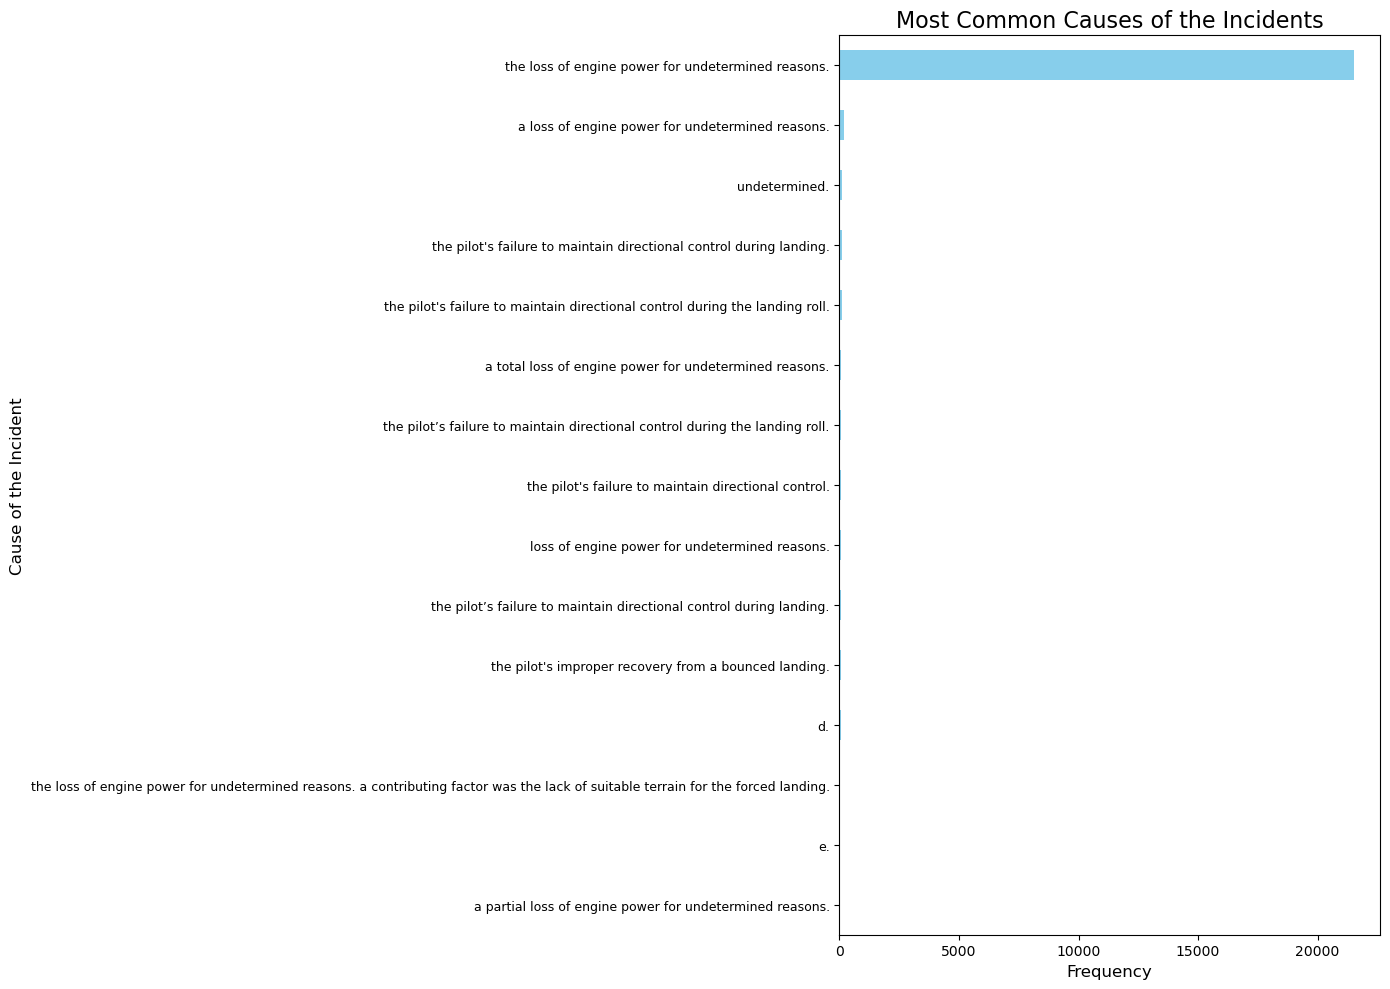

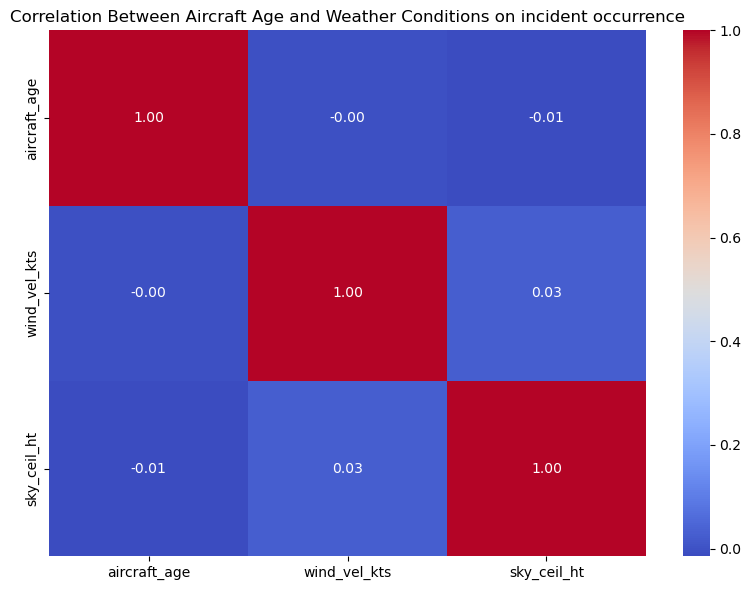

ANOVA: Aircraft Age and Lighting Condition
F-statistic: 0.3036
P-value: 0.8228


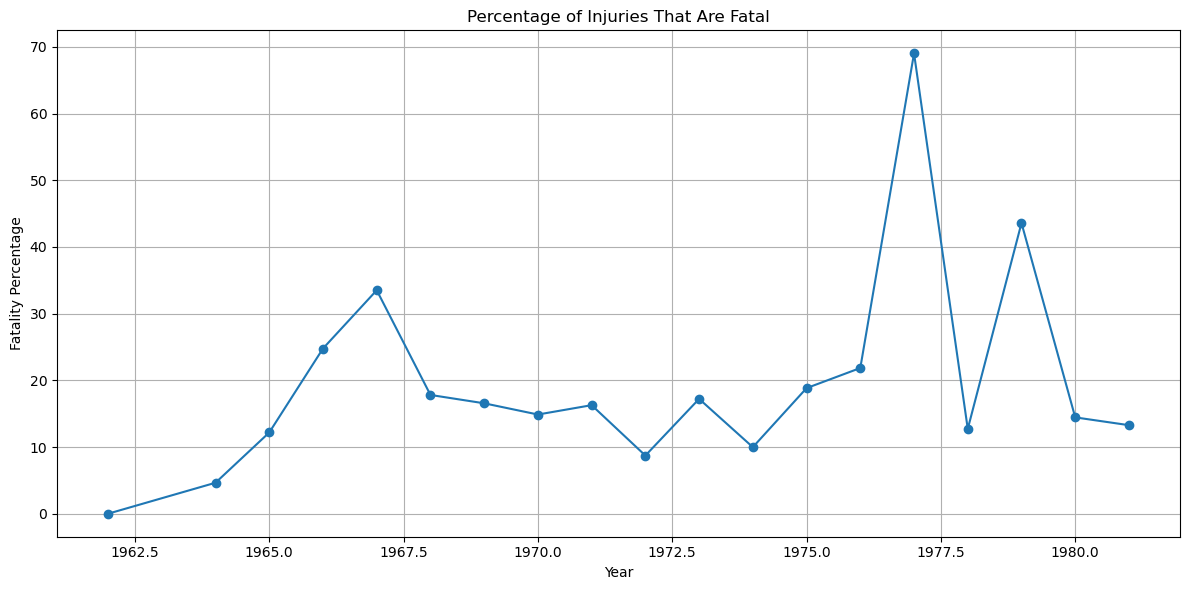

In [83]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from scipy.stats import f_oneway

# 2nd question
# Loading the combined dataset
dataset_combined = pd.read_csv("Master_Combined_Aircraft_Incidents.csv", low_memory=False)

# Cleaning narrative_cause column to ensure there are no empty spaces and characters
def clean_text(text):
    if pd.isnull(text):
        return None
    text = re.sub(r'<[^>]+>', '', text) 
    text = re.sub(r'\s+', ' ', text)    
    text = text.strip().lower()
    if text in ['', '.', '-', 'undetermined', 'none']:
        return None
    return text

# Applying the cleaning function to the column
dataset_combined['narrative_cause'] = dataset_combined['narrative_cause'].astype(str).apply(clean_text)
filtered_causes = dataset_combined['narrative_cause'].dropna()

# printing top 15 valid causes for the incident
topcauses_of_incident = filtered_causes.value_counts().head(15)
print("Top Most Frequent Causes of the incidents:")
print(topcauses_of_incident)

# Plotting the top causes of incidents, with horizontal layout to ensure proper visibility of cause description
plt.figure(figsize=(14, 10))
topcauses_of_incident.plot(kind='barh', color='skyblue')
plt.gca().invert_yaxis()
plt.title("Most Common Causes of the Incidents", fontsize=16)
plt.xlabel("Frequency", fontsize=12)
plt.ylabel("Cause of the Incident", fontsize=12)
plt.yticks(fontsize=9)
plt.xticks(fontsize=10)

plt.tight_layout()
plt.show()


# 3rd question
# Loading the post 2008 data
post_2008_data = pd.read_csv("Dataset_Post_2008.csv")

# Parsing the event date and compute incident year to calculate the aircraft age later
post_2008_data['ev_date'] = pd.to_datetime(post_2008_data['ev_date'], errors='coerce')
post_2008_data['incident_year'] = post_2008_data['ev_date'].dt.year

# Droping missing aircraft year and calculate aircraft age
post_2008_data = post_2008_data[post_2008_data['acft_year'].notnull()]
post_2008_data['aircraft_age'] = post_2008_data['incident_year'] - post_2008_data['acft_year']
post_2008_data = post_2008_data[(post_2008_data['aircraft_age'] >= 0) & (post_2008_data['aircraft_age'] <= 100)]

# Converting lighting conditions to consistent labels to ensure clarity
post_2008_data['light_cond'] = post_2008_data['light_cond'].astype(str).str.upper().str.strip()

# Correlation Heatmap for aircraft age and weather conditions
correlation_data = post_2008_data[['aircraft_age', 'wind_vel_kts', 'sky_ceil_ht']].dropna()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Aircraft Age and Weather Conditions on incident occurrence")
plt.tight_layout()
plt.show()

# ANOVA Test to check the correlation between aircraft age and lighting conditions on incident occurrence
post_2008_data = post_2008_data[post_2008_data['light_cond'].isin(['DAYL', 'NITE', 'DUSK', 'DAWN'])]
anova_groups = [group['aircraft_age'].dropna() for _, group in post_2008_data.groupby('light_cond')]
anova_result = f_oneway(*anova_groups)

print("ANOVA: Aircraft Age and Lighting Condition")
print(f"F-statistic: {anova_result.statistic:.4f}")
print(f"P-value: {anova_result.pvalue:.4f}")



# 9th question
# Loading the pre-1982 dataset
pre_1982_dataset = pd.read_csv("Dataset_Pre_1982.csv")

# Converting to datetime and extracting year
pre_1982_dataset['DATE_OCCURRENCE'] = pd.to_datetime(pre_1982_dataset['DATE_OCCURRENCE'], errors='coerce')
pre_1982_dataset['year'] = pre_1982_dataset['DATE_OCCURRENCE'].dt.year

# Injury columns in Pre-1982 to know the total injuries and number of fatal injuries
injury_columns = ['GRAND_TOTAL_FATAL', 'GRAND_TOTAL_SERIOUS', 'GRAND_TOTAL_MINOR', 'GRAND_TOTAL_NONE']

# Ensuring all injury columns are numeric
for col in injury_columns:
    pre_1982_dataset[col] = pd.to_numeric(pre_1982_dataset[col], errors='coerce').fillna(0)

# Computing total injuries from all the injuries columns
pre_1982_dataset['total_injuries'] = pre_1982_dataset[injury_columns].sum(axis=1)

# Grouping the number of injuries by year
no_of_injuries_year = pre_1982_dataset.groupby('year').agg({
    'GRAND_TOTAL_FATAL': 'sum',
    'total_injuries': 'sum'
}).reset_index()

# Calculating the percentage of injuries that are fatal
no_of_injuries_year['fatality_percent'] = (no_of_injuries_year['GRAND_TOTAL_FATAL'] / no_of_injuries_year['total_injuries']) * 100

# Droping years with 0 injuries to avoid division by zero to avoid errors
no_of_injuries_year = no_of_injuries_year[no_of_injuries_year['total_injuries'] > 0]

# Plotting the percentage of fatal injuries by year
plt.figure(figsize=(12, 6))
plt.plot(no_of_injuries_year['year'], no_of_injuries_year['fatality_percent'], marker='o', linestyle='-')
plt.title("Percentage of Injuries That Are Fatal")
plt.xlabel("Year")
plt.ylabel("Fatality Percentage")
plt.grid(True)
plt.tight_layout()
plt.show()

# Completed Milestones
Elaborated data description, acquisition, cleaning, and exploratory analysis were done as part of the first milestone.

# Methods Milestones
Descriptive Statistics were done as part of the first milestone.

# Schedule
April 1, 2025 | Model development and hypothesis testing
April 8, 2025 | Refinement and documentation
April 15, 2025 | Final submission and presentation preparation